In [1]:
import os
import glob
import numpy as np
import bottleneck as bn
import pandas as pd
import bootmedian as bm # This is a custom made module available at GitHub. https://github.com/Borlaff/bootmedian
from tqdm import tqdm
from astropy.io import fits
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import Video
from astropy.wcs import WCS
from reproject import reproject_interp
import sys
sys.path.append("/home/borlaff/NASA/SOFIA/MOHAWC/")
from mohawc import *
import seaborn as sns

nsimul = 1000

sigma1=0.682689492137086 
sigma2=0.954499736103642 
sigma3=0.997300203936740 

legacy_wd="/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/"
os.chdir("/home/borlaff/NASA/SOFIA/LEGACY/WORK_ZONE/")

#####
# Galaxy constants
#####

# Centaurus A 
cenA_center = [201.365063, -43.019113]
cenA_pa = 114
cenA_dpa = 14
cenA_incl = 83
cenA_dincl = 6

# Circinus
circinus_center = [213.29130,-65.33926] # For, Koribalski, Jarrett et al. 2012
circinus_incl = 40 # For, Koribalski, Jarrett et al. 2012
circinus_dincl = 10
circinus_pa = 205 # For, Koribalski, Jarrett et al. 2012
circinus_dpa = 10

# NGC253 
ngc253_center = [11.888002, -25.288220]
ngc253_pa = 52
ngc253_dpa = 1
ngc253_incl = 78.3
ngc253_dincl = 1
ngc253_dist = 3.5
ngc253_ddist = 0.1

# M51 
m51_incl = -22.0
m51_dincl = 5.0
m51_pa = -7.0  
m51_dpa = 3.0
m51_nbins = 14
m51_center = [202.4698899, +47.1952002]

# M82 
m82_center = [148.969687, 69.679383]
m82_pa = 64
m82_dpa = 1
m82_incl = 76
m82_dincl = 1

# M83
m83_center = [204.253958, -29.865417]
m83_pa = 226 # Foyle et al. 2012 
m83_dpa = 5
m83_incl = 25 # Coyle 1981
m83_dincl = 5

# NGC1068
ngc1068_center = [40.669629, -0.013281]
ngc1068_pa = 360-286
ngc1068_dpa = 5 # Das et al. 2006
ngc1068_incl = 40 
ngc1068_dincl = 3

# NGC1097
ngc1097_center = [41.579375, -30.274889] # Sheth et al 2010
ngc1097_pa = 133.0
ngc1097_dpa = 0.1
ngc1097_incl =  41.7
ngc1097_dincl =  0.6

# NGC2146
ngc2146_center = [94.657125, 78.357028]
ngc2146_pa = 140 # Sanchez-Portal+ 2000
ngc2146_dpa = 2 
ngc2146_incl = 63
ngc2146_dincl = 2

# NGC3627
ngc3627_center = [170.062351, 12.991538]
ngc3627_pa = 176
ngc3627_dpa = 1
ngc3627_incl = 52
ngc3627_dincl = 1

# NGC4736 
ngc4736_center = [192.721088, 41.120458]
ngc4736_pa = 292
ngc4736_dpa = 2 
ngc4736_incl = 36
ngc4736_dincl = 7
ngc4736_dist = 5.3
ngc4736_ddist = 0.1

# NGC4826
ngc4826_center = [194.181837, 21.682970]
ngc4826_pa = 125
ngc4826_dpa = 5
ngc4826_incl = 65
ngc4826_dincl = 5

# NGC6946
ngc6946_center = [308.718015, 60.153915]
ngc6946_pa = 239
ngc6946_dpa = 1 # Kuno+2007
ngc6946_incl = 38.4 # Kuno+2007
ngc6946_dincl = 3.0 # Kuno+2007

# NGC7331
ngc7331_center = [339.266724, 34.415519]
ngc7331_pa = 165
ngc7331_dpa = 1.2 
ngc7331_incl = 78.1
ngc7331_dincl = 2.7




# For the pitch angle of the baryonic spiral arms - Patrikeev et al (2006)
# For the galaxy centre, inclination and position angle - Colombo et al (2014).
# For the corotation radii of the bar/arm features and their pattern speeds - Querejeta et al (2016).
# PA= (173±3)◦) and inclination (i= (22±5)◦

# SNR_p >=2, SNR_pi >=2, p<=30, y SNR_I >= 50, excepto para M82, NGC 253 y NGC 2146, con SNR_I >= 80.

SNR_pol_limit_HAWC = 2
SNR_polflux_limit_HAWC = 2
SNR_int_limit_HAWC = 50 # np.sqrt(SNR_pol_limit_HAWC)/(0.05)
#SNR_pol_limit_Eff100m = 2
#SNR_int_limit_Eff100m = 2 #np.sqrt(2)/(1-sigma2)
save_temp=False

SNR_int_limit = SNR_int_limit_HAWC
SNR_pol_limit = SNR_pol_limit_HAWC
SNR_polflux_limit = SNR_polflux_limit_HAWC
p_limit = 30

Astrobox v.1.0
Astronomy Imaging Tool Box - A box of usual tools for astronomical imaging processing
Author: Alejandro S. Borlaff - NASA Ames Research Center - a.s.borlaff@nasa.gov / asborlaff@gmail.com


In [2]:
ngc1068_pa

74

(array([   3.,   10.,   33.,   76.,  159.,  354.,  642.,  910., 1307.,
        1595., 1532., 1293.,  937.,  586.,  349.,  127.,   53.,   24.,
           7.,    3.]),
 array([-2.94646739, -2.54816964, -2.14987188, -1.75157413, -1.35327638,
        -0.95497863, -0.55668087, -0.15838312,  0.23991463,  0.63821238,
         1.03651013,  1.43480789,  1.83310564,  2.23140339,  2.62970114,
         3.02799889,  3.42629665,  3.8245944 ,  4.22289215,  4.6211899 ,
         5.01948766]),
 <BarContainer object of 20 artists>)

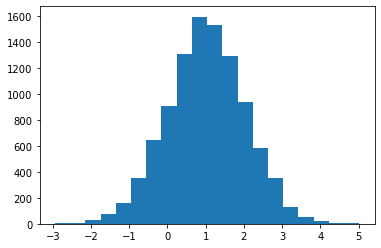

In [3]:
# Test histogram 
a = np.random.normal(1,1,(100,100))
plt.hist(a.ravel(), bins=20)

In [4]:
# List all the input files 
HAWC_obs = sorted(glob.glob(legacy_wd + "*.fits"))
HAWC_obs

['/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/CentaurusA_C.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/Circinus_A.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/Circinus_C.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/Circinus_E.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/M51_D.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/M82_A.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/M82_C.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/M82_D.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/M82_E.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/M83_D.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/NGC1068_A.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/NGC1068_C.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/NGC1097_C.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/NGC1097_D.fits',
 '/home/borlaff/NASA/SOFIA/LEGACY/DR1_20210103/Data/

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

41.21622553584378 32.82906380480039


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/39 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  5%|▌         | 2/39 [00:00<00:01, 18.93it/s]

Simulations done, generating profile from cube


  0%|          | 0/68 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▌         | 4/68 [00:00<00:01, 39.38it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    0.892804   0.955848   0.857370   0.994215   0.771146        NaN   
1    1.525439   1.786752   1.306684   1.961144   1.066439        NaN   
2    3.147378   3.453229   2.850382   3.773376   2.391853        NaN   
3    4.499204   4.705571   4.306450   4.909059   4.098948        NaN   
4    5.498981   5.699902   5.308759   5.879232   5.116146   6.831414   
5    7.067295   7.312758   6.821829   7.612240   6.455450  13.036525   
6    8.514918   8.678751   8.326864   8.884677   8.153802  21.839623   
7   10.046529  10.281633   9.828245  10.608208   9.523897  28.254705   
8   11.512346  11.663046  11.345973  11.851573  11.224998  31.185328   
9   12.499529  12.647846  12.340456  12.824709  12.202335  35.428034   
10  14.047773  14.245192  13.841789  14.544769  13.486037  35.646586   
11  15.504431  15.642430  15.368578  15.807880  15.206464  37.821661   
12  17.027351  17.209596  16.851541  17.474198  16.544710  39.14

100%|██████████| 68/68 [00:01<00:00, 39.27it/s]


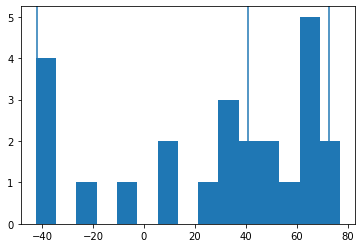

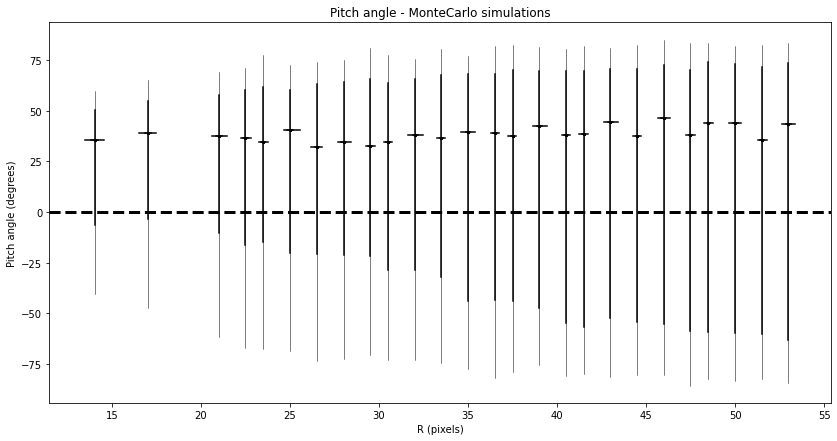

    index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      10  14.047773  14.245192  13.841789  14.544769  13.486037  35.646586   
1      12  17.027351  17.209596  16.851541  17.474198  16.544710  39.140122   
2      15  21.015802  21.186015  20.863227  21.443879  20.613108  37.661696   
3      16  22.502649  22.628141  22.382944  22.788604  22.232566  36.747185   
4      17  23.501412  23.626669  23.395066  23.788504  23.257544  34.822513   
5      18  25.018313  25.170658  24.860547  25.540930  24.661721  40.550714   
6      19  26.498976  26.610064  26.386513  26.803937  26.204362  32.301151   
7      20  28.015096  28.168225  27.881773  28.440055  27.704076  34.598693   
8      21  29.503229  29.612606  29.400677  29.758510  29.267431  32.857745   
9      22  30.502852  30.602818  30.400127  30.734148  30.277013  34.775077   
10     23  32.017484  32.167455  31.897770  32.466730  31.643132  37.877539   
11     24  33.496351  33.594465  33.401281  33.73475

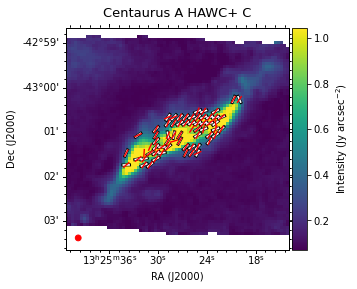

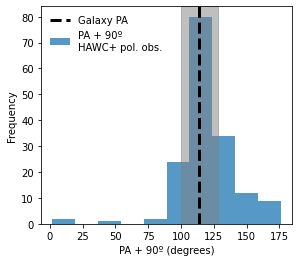

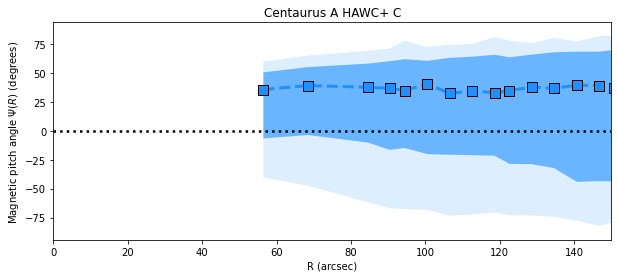

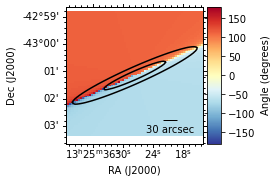

In [5]:
# Centaurus A
image_input=legacy_wd+"CentaurusA_C.fits"
name="CenA_C_"
source_center = cenA_center
PA = cenA_pa
dPA = cenA_dpa
incl = cenA_incl
dincl = cenA_dincl
nbins = 40
SNR_int_limit = SNR_int_limit_HAWC
SNR_pol_limit = SNR_pol_limit_HAWC
SNR_polflux_limit = SNR_polflux_limit_HAWC

plot_title = r'Centaurus A HAWC+ C'
max_radii = 150 

#cenA_profile
cenA_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                      PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                      SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                      SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                      plot_title=plot_title, profile_color="dodgerblue", max_radii=max_radii)



43.386780564210966 36.41683359476493


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/49 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▌         | 3/49 [00:00<00:02, 20.37it/s]

Simulations done, generating profile from cube


  0%|          | 0/78 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▋         | 5/78 [00:00<00:01, 40.76it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    0.748220   0.749789   0.746762   0.751723   0.745558        NaN   
1    1.717292   1.727690   1.687971   1.734825   1.683837        NaN   
2    2.681519   2.693022   2.601052   2.698124   2.555236        NaN   
3    3.624605   3.651398   3.539862   3.664443   3.514890        NaN   
4    4.555718   4.569693   4.537403   4.583610   4.523166        NaN   
5    6.060461   6.083573   6.028946   6.097245   5.995820  28.244291   
6    7.534138   7.562949   7.422938   7.599993   7.381343 -77.362102   
7    8.421133   8.528246   8.384547   8.583028   8.363089 -76.326944   
8    9.466157   9.514972   9.436983   9.551661   9.414210 -78.346272   
9   10.508291  10.551615  10.475375  10.579719  10.445915 -79.434748   
10  11.998982  12.028813  11.976251  12.051820  11.963211 -82.324157   
11  13.419886  13.460981  13.400242  13.502757  13.384266  41.910975   
12  14.456491  14.500995  14.423615  14.535644  14.407230  73.10

100%|██████████| 78/78 [00:03<00:00, 21.55it/s]


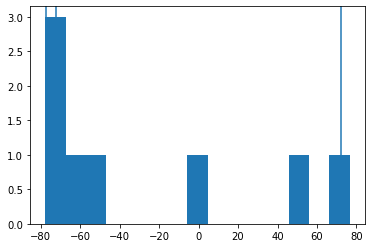

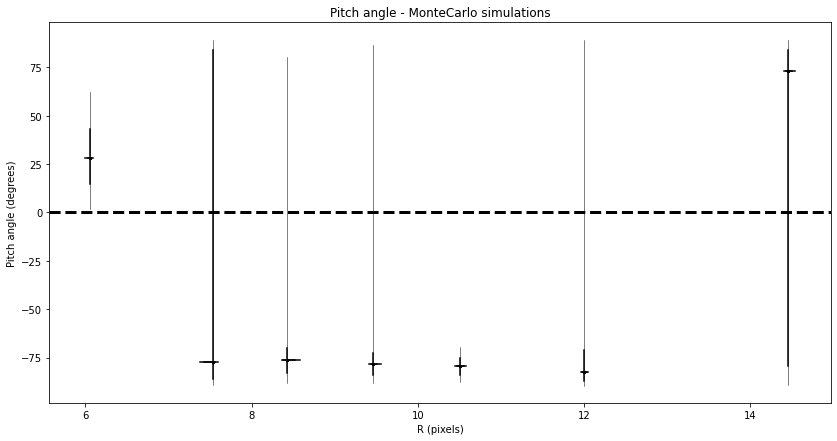

   index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      5   6.060461   6.083573   6.028946   6.097245   5.995820  28.244291   
1      6   7.534138   7.562949   7.422938   7.599993   7.381343 -77.362102   
2      7   8.421133   8.528246   8.384547   8.583028   8.363089 -76.326944   
3      8   9.466157   9.514972   9.436983   9.551661   9.414210 -78.346272   
4      9  10.508291  10.551615  10.475375  10.579719  10.445915 -79.434748   
5     10  11.998982  12.028813  11.976251  12.051820  11.963211 -82.324157   
6     12  14.456491  14.500995  14.423615  14.535644  14.407230  73.104059   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down   npix  
0   43.146713     14.515053   62.244010      1.643378  1.000  
1   84.020473    -86.126270   89.110374    -89.416321  3.026  
2  -70.251648    -82.753997   80.081769    -87.967925  3.974  
3  -72.841693    -83.894178   86.243668    -87.997119  3.150  
4  -74.986751    -83.772509  -69.390677    -87.826592  7.030

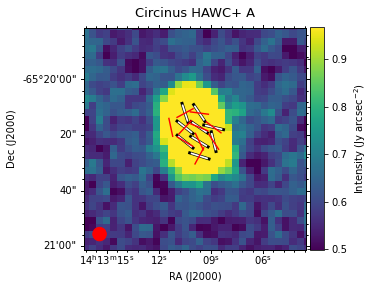

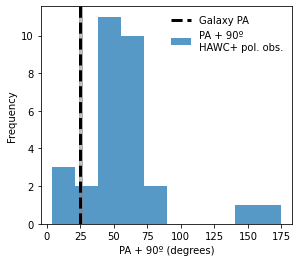

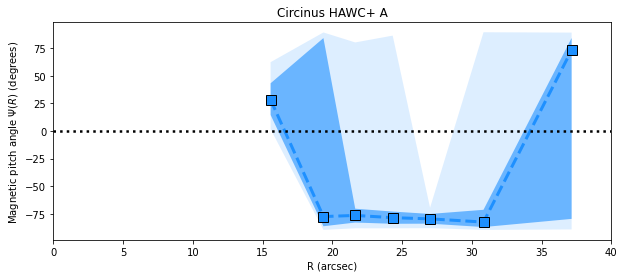

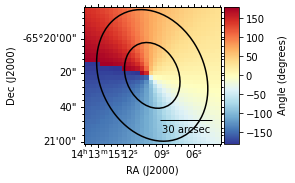

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

50.79904660239479 48.7671286473544


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  4%|▍         | 2/49 [00:00<00:02, 17.74it/s]

Simulations done, generating profile from cube


 16%|█▋        | 8/49 [00:00<00:02, 16.29it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/101 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  4%|▍         | 4/101 [00:00<00:02, 38.15it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    0.839061   0.840820   0.837485   0.842924   0.836127  11.073715   
1    1.518435   1.527917   1.507893   1.537581   1.496505 -65.745913   
2    3.072331   3.130524   3.060240   3.160088   3.058541  -5.883949   
3    4.451478   4.508069   4.373943   4.557565   4.359328 -20.337215   
4    6.011670   6.027721   5.993138   6.044860   5.978515   4.870109   
5    7.510478   7.528699   7.488592   7.548841   7.464274  -6.390228   
6    9.027656   9.054999   9.014340   9.083256   8.990352  12.866809   
7   10.456757  10.519031  10.413656  10.543701  10.384831  40.941410   
8   12.033721  12.085290  12.003109  12.123274  11.989757  60.556579   
9   13.523753  13.578708  13.495519  13.607201  13.476939        NaN   
10  15.056817  15.073010  15.030906  15.092186  15.001003        NaN   
11  16.524543  16.554591  16.491677  16.584816  16.464145        NaN   
12  18.049798  18.080897  18.023294  18.103374  18.002300       

100%|██████████| 101/101 [00:04<00:00, 22.72it/s]


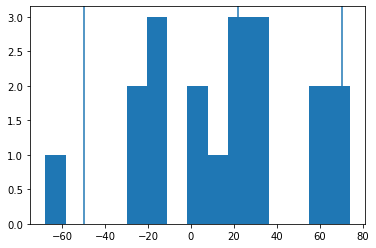

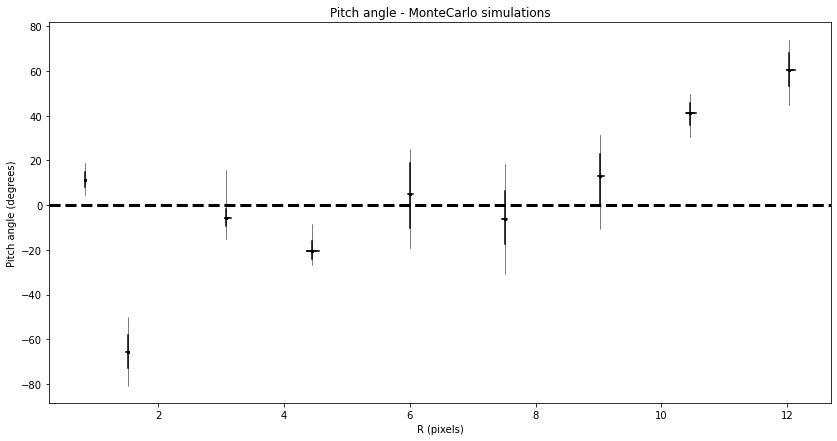

   index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      0   0.839061   0.840820   0.837485   0.842924   0.836127  11.073715   
1      1   1.518435   1.527917   1.507893   1.537581   1.496505 -65.745913   
2      2   3.072331   3.130524   3.060240   3.160088   3.058541  -5.883949   
3      3   4.451478   4.508069   4.373943   4.557565   4.359328 -20.337215   
4      4   6.011670   6.027721   5.993138   6.044860   5.978515   4.870109   
5      5   7.510478   7.528699   7.488592   7.548841   7.464274  -6.390228   
6      6   9.027656   9.054999   9.014340   9.083256   8.990352  12.866809   
7      7  10.456757  10.519031  10.413656  10.543701  10.384831  40.941410   
8      8  12.033721  12.085290  12.003109  12.123274  11.989757  60.556579   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0   14.995307      7.853085   18.753343      4.550629   3.000  
1  -58.225743    -72.916343  -49.961518    -80.683902   6.000  
2   -1.963991     -9.236132

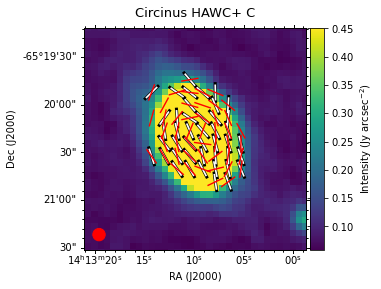

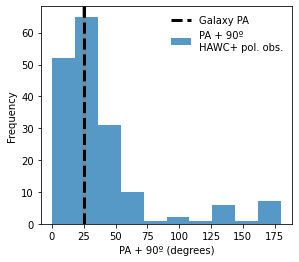

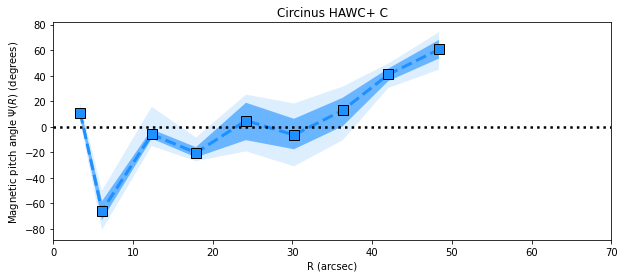

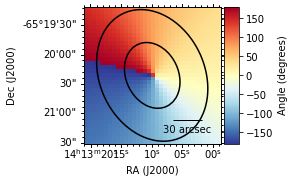

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

37.80126585042254 30.77615037370698


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/49 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▌         | 3/49 [00:00<00:01, 24.16it/s]

Simulations done, generating profile from cube


  0%|          | 0/70 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    0.839737   0.841491   0.838125   0.843774   0.836756        NaN   
1    1.515252   1.525676   1.503607   1.538011   1.493098        NaN   
2    2.376904   2.387568   2.368255   2.405208   2.362756  31.483159   
3    3.458641   3.480292   3.439024   3.625494   3.417836  19.995320   
4    4.454998   4.501235   4.373211   4.558959   4.361202   8.931169   
5    5.479783   5.533468   5.413089   5.567903   5.394660  -2.506382   
6    6.537124   6.576539   6.514314   6.594343   6.503094 -17.623342   
7    7.508311   7.527014   7.490015   7.552177   7.467162  41.137280   
8    8.525754   8.552096   8.496756   8.607392   8.447293  66.023707   
9    9.509415   9.534504   9.487974   9.573745   9.461948  68.517544   
10  10.456359  10.514620  10.408574  10.547998  10.378043  75.233956   
11  11.521992  11.573847  11.488471  11.603799  11.456289  61.929859   
12  12.502608  12.532947  12.454188  12.552131  12.412397  43.20

100%|██████████| 70/70 [00:01<00:00, 40.16it/s]


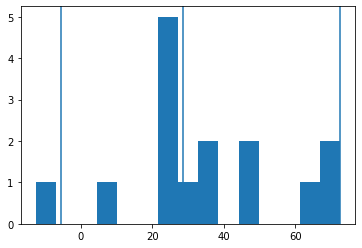

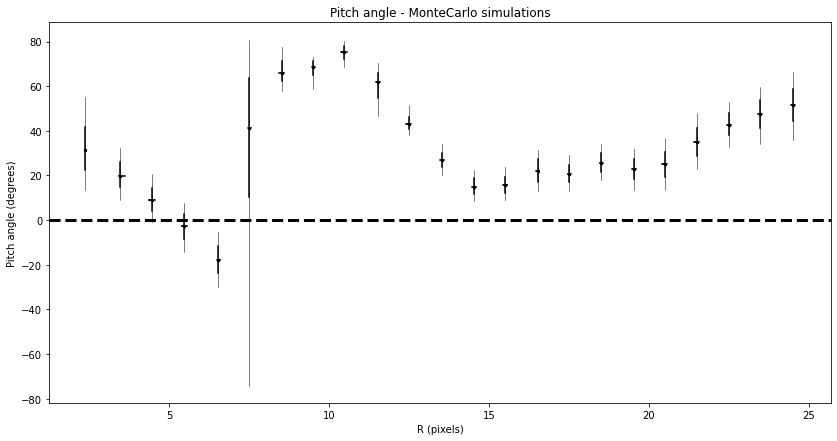

    index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0       2   2.376904   2.387568   2.368255   2.405208   2.362756  31.483159   
1       3   3.458641   3.480292   3.439024   3.625494   3.417836  19.995320   
2       4   4.454998   4.501235   4.373211   4.558959   4.361202   8.931169   
3       5   5.479783   5.533468   5.413089   5.567903   5.394660  -2.506382   
4       6   6.537124   6.576539   6.514314   6.594343   6.503094 -17.623342   
5       7   7.508311   7.527014   7.490015   7.552177   7.467162  41.137280   
6       8   8.525754   8.552096   8.496756   8.607392   8.447293  66.023707   
7       9   9.509415   9.534504   9.487974   9.573745   9.461948  68.517544   
8      10  10.456359  10.514620  10.408574  10.547998  10.378043  75.233956   
9      11  11.521992  11.573847  11.488471  11.603799  11.456289  61.929859   
10     12  12.502608  12.532947  12.454188  12.552131  12.412397  43.203420   
11     13  13.526310  13.578049  13.497190  13.60635

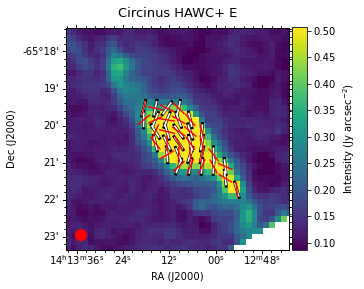

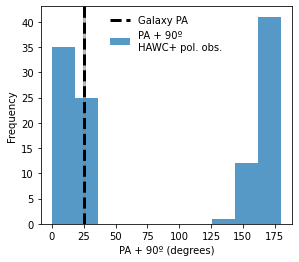

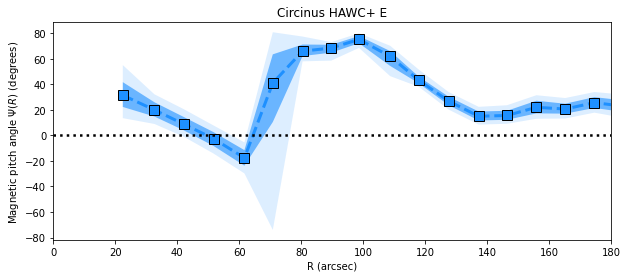

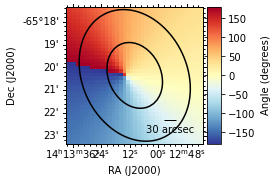

In [6]:
# Circinus A
image_input=legacy_wd+"Circinus_A.fits"
name="Circinus_A_"
source_center = circinus_center
PA = circinus_pa
dPA = 1
incl = circinus_incl
dincl = 1
nbins = 50

plot_title = r'Circinus HAWC+ A'

circinus_a_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=40)

image_input=legacy_wd+"Circinus_C.fits"
name="Circinus_C_"
plot_title = r'Circinus HAWC+ C'
circinus_c_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=70)

image_input=legacy_wd+"Circinus_E.fits"
name="Circinus_E_"
plot_title = r'Circinus HAWC+ E'
circinus_e_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=180)

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

40.33987384847091 42.752077642865544


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 22%|██▏       | 2/9 [00:00<00:00, 18.33it/s]

Simulations done, generating profile from cube


  0%|          | 0/86 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


           R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0   4.054466   4.205502   3.922471   4.378225   3.836250   6.034215   
1  10.065715  10.229703   9.965332  10.359435   9.848316 -26.970143   
2  16.854496  16.961495  16.785389  17.034694  16.716227 -59.491624   
3  23.196947  23.262456  23.132642  23.328514  23.074847 -30.308640   
4  29.689737  29.773607  29.627424  29.836538  29.576982   7.319990   
5  36.659513  36.726494  36.607734  36.797006  36.538706   9.591469   
6  43.103609  43.151431  43.063111  43.197462  43.024440 -42.088461   
7  49.563682  49.618343  49.502213  49.672090  49.440335 -48.541942   
8  56.332198  56.400731  56.271452  56.475145  56.213967 -77.672469   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0   16.905189     -9.907014   27.378221    -25.230176  20.336  
1  -18.750308    -35.742191  -10.117390    -42.111955  42.220  
2  -49.745278    -66.618819  -31.616972    -75.757120  25.969  
3  -16.080649    -54.791629   11.

100%|██████████| 86/86 [00:02<00:00, 38.50it/s]


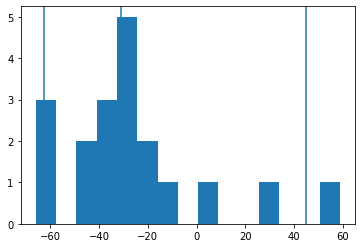

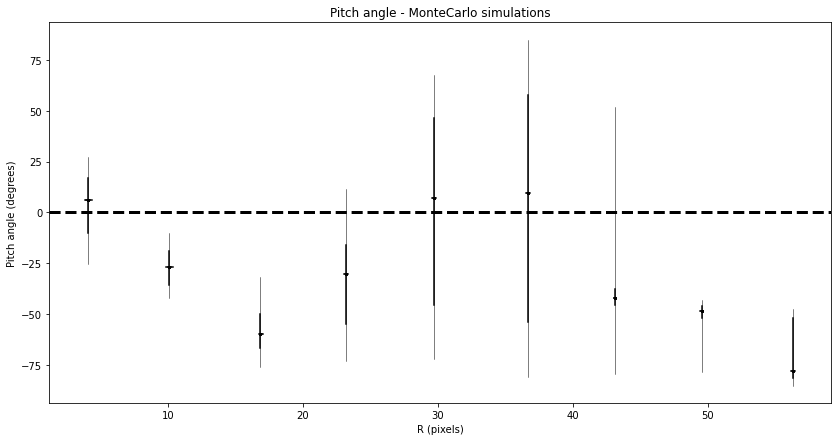

   index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      0   4.054466   4.205502   3.922471   4.378225   3.836250   6.034215   
1      1  10.065715  10.229703   9.965332  10.359435   9.848316 -26.970143   
2      2  16.854496  16.961495  16.785389  17.034694  16.716227 -59.491624   
3      3  23.196947  23.262456  23.132642  23.328514  23.074847 -30.308640   
4      4  29.689737  29.773607  29.627424  29.836538  29.576982   7.319990   
5      5  36.659513  36.726494  36.607734  36.797006  36.538706   9.591469   
6      6  43.103609  43.151431  43.063111  43.197462  43.024440 -42.088461   
7      7  49.563682  49.618343  49.502213  49.672090  49.440335 -48.541942   
8      8  56.332198  56.400731  56.271452  56.475145  56.213967 -77.672469   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0   16.905189     -9.907014   27.378221    -25.230176  20.336  
1  -18.750308    -35.742191  -10.117390    -42.111955  42.220  
2  -49.745278    -66.618819

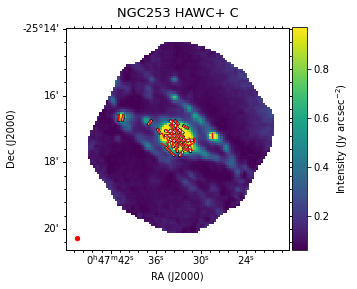

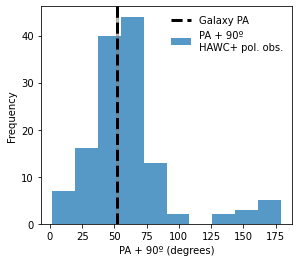

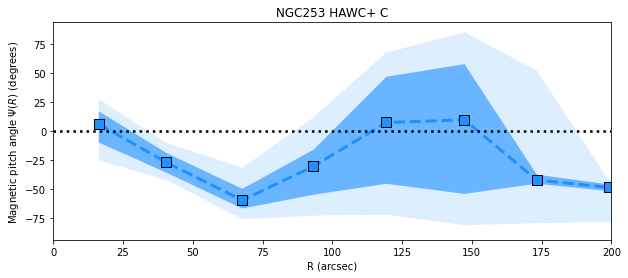

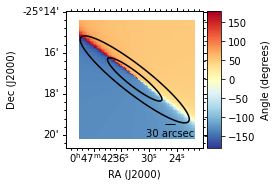

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

31.98222902625441 34.925860237198506


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 33%|███▎      | 3/9 [00:00<00:00, 19.78it/s]

Simulations done, generating profile from cube


 56%|█████▌    | 5/9 [00:00<00:00, 18.69it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/71 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▌         | 4/71 [00:00<00:02, 32.19it/s]

           R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0   3.430399   3.604068   3.304712   3.780162   3.188986 -38.655675   
1   7.930724   8.042464   7.824705   8.119980   7.718233 -54.020739   
2  12.763044  12.857112  12.664988  12.949828  12.576605 -70.836265   
3  18.241130  18.344496  18.165578  18.466323  18.088154 -62.916939   
4  23.641933  23.731676  23.560505  23.808492  23.484488 -31.014180   
5  28.604310  28.688214  28.529186  28.761238  28.462773 -43.096686   
6  34.111191  34.164448  34.046717  34.213727  33.992189        NaN   
7  39.508754  39.594591  39.435394  39.669991  39.364381        NaN   
8  44.406294  44.489088  44.329192  44.593665  44.265017        NaN   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0  -27.581536    -48.220749  -14.484176    -57.818604   8.469  
1  -48.111676    -59.240923  -40.693248    -64.006019  20.469  
2  -64.116260    -76.330396  -54.701874    -82.283504  12.062  
3  -28.805879    -74.706241   83.

100%|██████████| 71/71 [00:02<00:00, 35.27it/s]


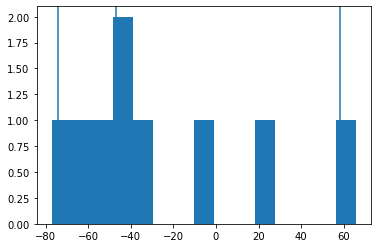

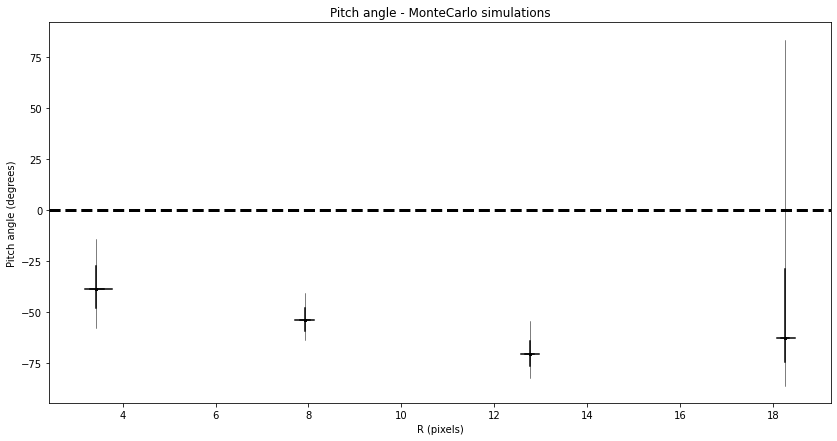

   index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      0   3.430399   3.604068   3.304712   3.780162   3.188986 -38.655675   
1      1   7.930724   8.042464   7.824705   8.119980   7.718233 -54.020739   
2      2  12.763044  12.857112  12.664988  12.949828  12.576605 -70.836265   
3      3  18.241130  18.344496  18.165578  18.466323  18.088154 -62.916939   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0  -27.581536    -48.220749  -14.484176    -57.818604   8.469  
1  -48.111676    -59.240923  -40.693248    -64.006019  20.469  
2  -64.116260    -76.330396  -54.701874    -82.283504  12.062  
3  -28.805879    -74.706241   83.370096    -86.093895   1.001  
Max radii: 200


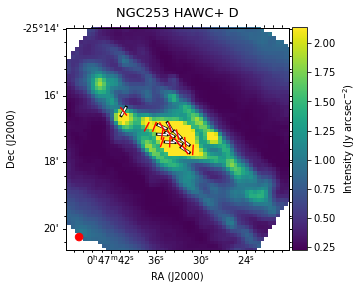

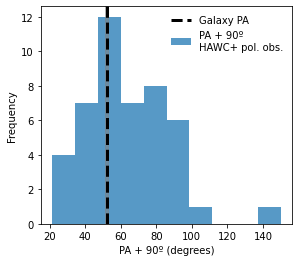

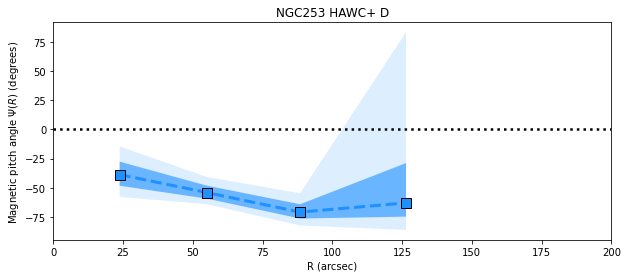

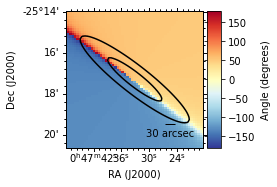

In [7]:
# NGC253


image_input=legacy_wd+"NGC253_C.fits"
name="NGC253_C_"
source_center = ngc253_center
PA = ngc253_pa
dPA = ngc253_dpa
incl = ngc253_incl
dincl = ngc253_dincl
nbins = 10
SNR_int_limit = 80 # Custom limit
SNR_pol_limit = SNR_pol_limit_HAWC
plot_title = r'NGC253 HAWC+ C'

ngc253_c_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=200)

image_input=legacy_wd+"NGC253_D.fits"
name="NGC253_D_"
source_center = ngc253_center
nbins = 10
SNR_int_limit = SNR_int_limit_HAWC
SNR_pol_limit = SNR_pol_limit_HAWC
plot_title = r'NGC253 HAWC+ D'

ngc253_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=200)

33.561833602239304 31.41210297444278


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 16%|█▌        | 3/19 [00:00<00:00, 21.62it/s]

Simulations done, generating profile from cube


 58%|█████▊    | 11/19 [00:00<00:00, 16.75it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/66 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▌         | 4/66 [00:00<00:01, 38.63it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    1.576050   1.593282   1.552010   1.601805   1.530600  36.352642   
1    3.802502   3.837506   3.776893   3.858975   3.753962  18.478369   
2    6.059701   6.102959   6.035160   6.154353   6.016860  18.526317   
3    8.632449   8.662307   8.606635   8.688981   8.596151  25.175864   
4   11.062256  11.092889  11.032254  11.116340  11.008257  27.739660   
5   13.598070  13.631151  13.576335  13.650726  13.553202  29.336128   
6   16.039069  16.069616  16.012847  16.094361  15.984501  25.877853   
7   18.588363  18.615712  18.561942  18.631430  18.534276  20.909138   
8   21.023828  21.045585  20.998351  21.066172  20.978469  27.494882   
9   23.577440  23.596733  23.548347  23.611217  23.529308  17.560920   
10  26.019895  26.041888  25.998101  26.060389  25.981618  -0.042936   
11  28.568009  28.589105  28.544784  28.611411  28.525607  21.562783   
12  31.015458  31.040190  30.994457  31.056766  30.977167       

100%|██████████| 66/66 [00:01<00:00, 40.47it/s]


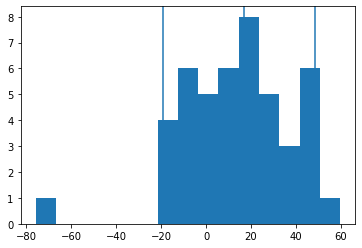

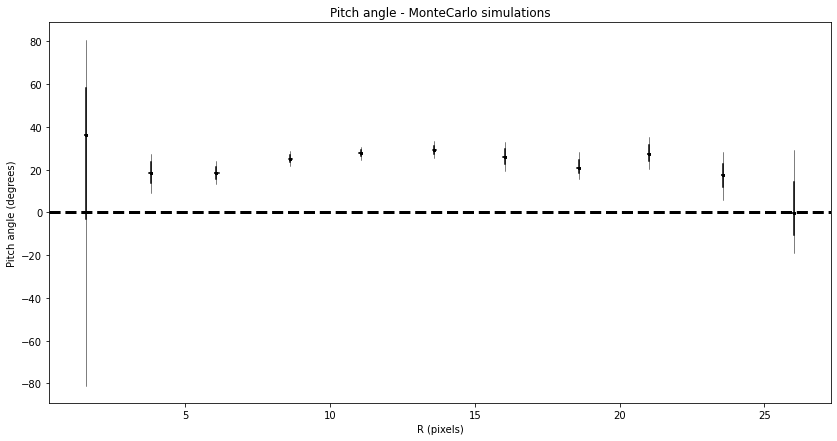

    index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0       0   1.576050   1.593282   1.552010   1.601805   1.530600  36.352642   
1       1   3.802502   3.837506   3.776893   3.858975   3.753962  18.478369   
2       2   6.059701   6.102959   6.035160   6.154353   6.016860  18.526317   
3       3   8.632449   8.662307   8.606635   8.688981   8.596151  25.175864   
4       4  11.062256  11.092889  11.032254  11.116340  11.008257  27.739660   
5       5  13.598070  13.631151  13.576335  13.650726  13.553202  29.336128   
6       6  16.039069  16.069616  16.012847  16.094361  15.984501  25.877853   
7       7  18.588363  18.615712  18.561942  18.631430  18.534276  20.909138   
8       8  21.023828  21.045585  20.998351  21.066172  20.978469  27.494882   
9       9  23.577440  23.596733  23.548347  23.611217  23.529308  17.560920   
10     10  26.019895  26.041888  25.998101  26.060389  25.981618  -0.042936   

    pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2d

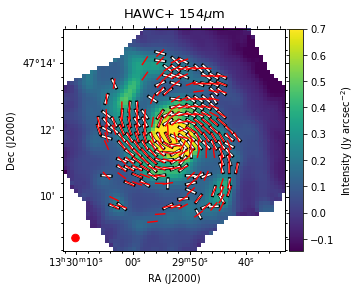

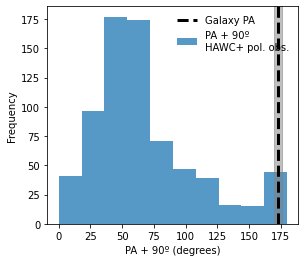

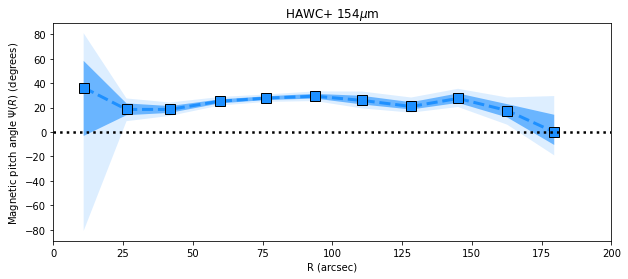

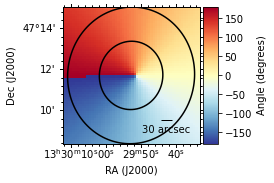

In [8]:
# M51
image_input=legacy_wd+"M51_D.fits"
name="M51_D_"
source_center = m51_center
PA = m51_pa
dPA = m51_dpa
incl = m51_incl
dincl = m51_dincl
nbins = 20
SNR_int_limit = SNR_int_limit_HAWC
SNR_pol_limit = SNR_pol_limit_HAWC
plot_title = r'HAWC+ 154$\mu$m'

m51_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=200)

63.09060216030906 57.87826321070995


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 11%|█         | 2/19 [00:00<00:01, 12.14it/s]

Simulations done, generating profile from cube


 63%|██████▎   | 12/19 [00:01<00:00,  9.73it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/122 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  3%|▎         | 4/122 [00:00<00:03, 37.57it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    2.449115   2.903061   2.385731   2.984107   2.335072  79.279432   
1    6.944373   7.059364   6.848975   7.115342   6.720091 -47.851690   
2   11.161252  11.247092  11.093260  11.341587  11.056485 -55.871729   
3   15.697234  15.819068  15.601604  15.888134  15.519615 -61.802564   
4   20.653004  20.761666  20.530898  20.839841  20.423598 -81.015826   
5   25.081133  25.133952  25.035907  25.188244  24.990482  74.717587   
6   29.610062  29.703816  29.511047  29.785081  29.415796  76.731145   
7   34.062655  34.108248  34.022056  34.146638  33.980256  77.133099   
8   38.586293  38.671735  38.503411  38.737237  38.432655  75.893927   
9   43.563512  43.647969  43.493339  43.713554  43.433043  76.578193   
10  48.044580  48.078271  48.013414  48.110733  47.980639  77.407747   
11  52.560261  52.632542  52.495267  52.690770  52.429644  81.468543   
12  57.554326  57.617730  57.483920  57.685502  57.433054       

100%|██████████| 122/122 [00:03<00:00, 38.05it/s]


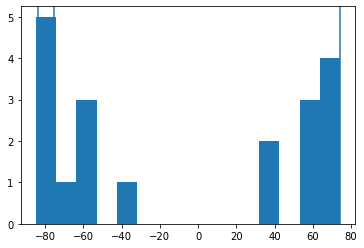

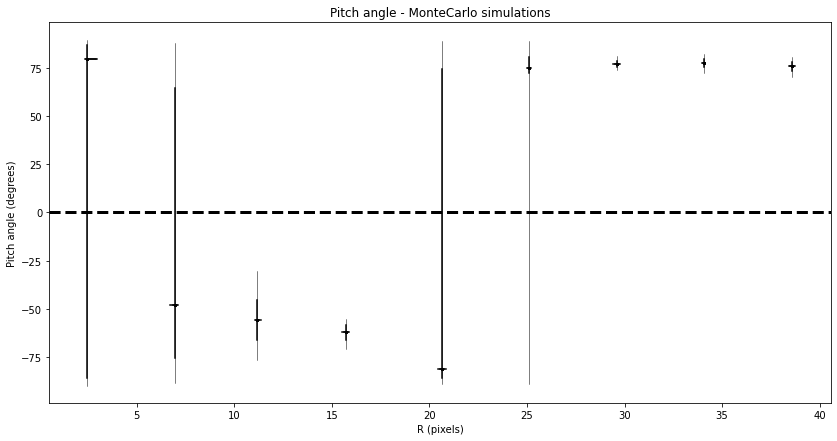

   index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      0   2.449115   2.903061   2.385731   2.984107   2.335072  79.279432   
1      1   6.944373   7.059364   6.848975   7.115342   6.720091 -47.851690   
2      2  11.161252  11.247092  11.093260  11.341587  11.056485 -55.871729   
3      3  15.697234  15.819068  15.601604  15.888134  15.519615 -61.802564   
4      4  20.653004  20.761666  20.530898  20.839841  20.423598 -81.015826   
5      5  25.081133  25.133952  25.035907  25.188244  24.990482  74.717587   
6      6  29.610062  29.703816  29.511047  29.785081  29.415796  76.731145   
7      7  34.062655  34.108248  34.022056  34.146638  33.980256  77.133099   
8      8  38.586293  38.671735  38.503411  38.737237  38.432655  75.893927   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0   86.889654    -85.654383   89.506282    -89.585666  11.481  
1   64.434110    -75.550208   87.566334    -88.187591  36.078  
2  -45.525046    -66.174734

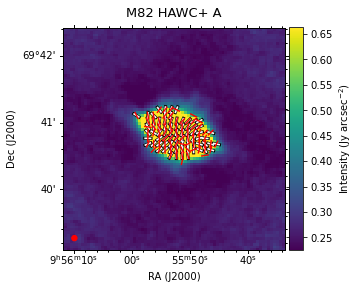

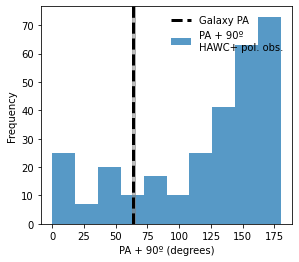

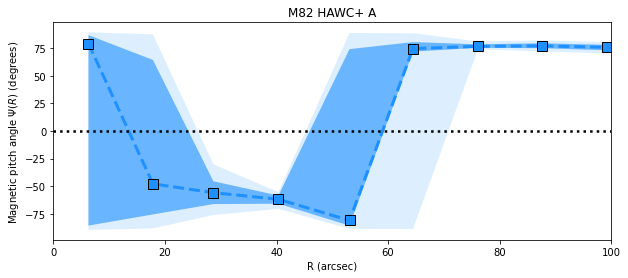

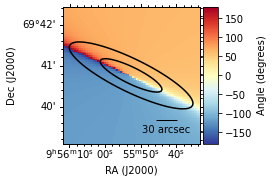

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

53.959663570147846 50.9221732466479


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 11%|█         | 2/19 [00:00<00:01, 13.75it/s]

Simulations done, generating profile from cube


  0%|          | 0/107 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    2.423048   2.498539   2.356889   2.820462   2.289056 -70.175444   
1    6.249637   6.383972   6.165698   6.487762   6.086906  44.061777   
2   10.172064  10.263519  10.110179  10.360230  10.060297 -76.300280   
3   14.177487  14.242841  14.105378  14.296079  14.047794  80.191883   
4   18.084512  18.143327  18.034572  18.212837  17.994267  82.373488   
5   22.090747  22.146517  22.045571  22.201382  22.005237  86.716253   
6   26.080348  26.133622  26.033465  26.179691  26.001116  86.999628   
7   30.056850  30.099498  30.022575  30.141805  29.992218  86.445072   
8   34.065239  34.104433  34.030259  34.149689  33.993824  85.279305   
9   38.060258  38.097216  38.021602  38.128879  37.989474  83.681742   
10  42.053750  42.089610  42.020232  42.123256  41.988058  83.093828   
11  46.050152  46.083455  46.019261  46.115774  45.989411  83.910026   
12  50.045186  50.076304  50.018536  50.108656  49.988571  76.31

100%|██████████| 107/107 [00:02<00:00, 37.34it/s]


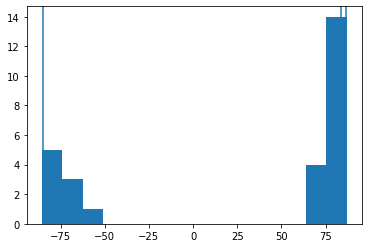

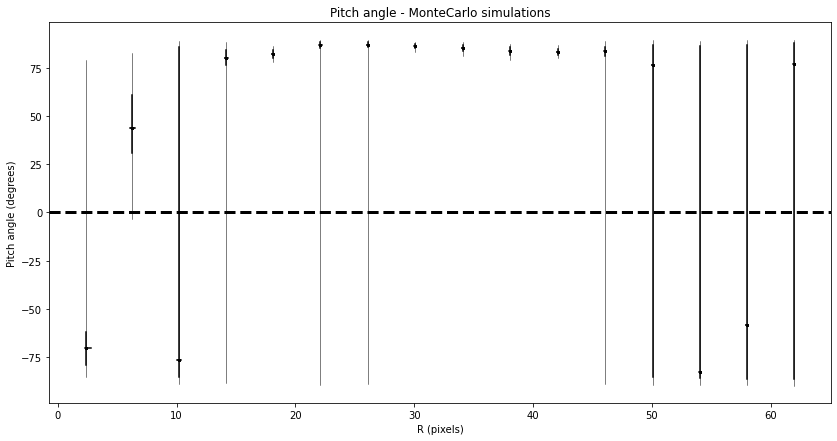

    index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0       0   2.423048   2.498539   2.356889   2.820462   2.289056 -70.175444   
1       1   6.249637   6.383972   6.165698   6.487762   6.086906  44.061777   
2       2  10.172064  10.263519  10.110179  10.360230  10.060297 -76.300280   
3       3  14.177487  14.242841  14.105378  14.296079  14.047794  80.191883   
4       4  18.084512  18.143327  18.034572  18.212837  17.994267  82.373488   
5       5  22.090747  22.146517  22.045571  22.201382  22.005237  86.716253   
6       6  26.080348  26.133622  26.033465  26.179691  26.001116  86.999628   
7       7  30.056850  30.099498  30.022575  30.141805  29.992218  86.445072   
8       8  34.065239  34.104433  34.030259  34.149689  33.993824  85.279305   
9       9  38.060258  38.097216  38.021602  38.128879  37.989474  83.681742   
10     10  42.053750  42.089610  42.020232  42.123256  41.988058  83.093828   
11     11  46.050152  46.083455  46.019261  46.11577

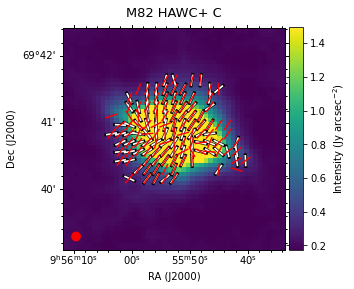

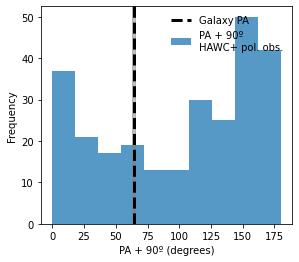

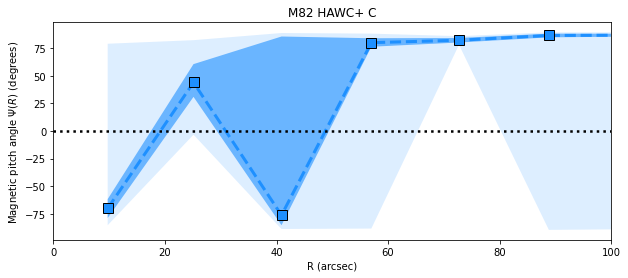

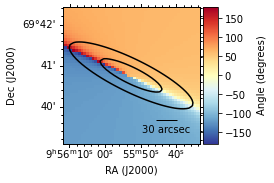

41.606471508224296 38.954853744808744


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 16%|█▌        | 3/19 [00:00<00:00, 20.01it/s]

Simulations done, generating profile from cube


  0%|          | 0/80 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▋         | 5/80 [00:00<00:01, 40.23it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    2.106717   2.234860   1.974022   2.343371   1.819876  -1.113466   
1    4.777337   4.857492   4.632970   4.995465   4.555241 -59.282490   
2    7.684182   7.754238   7.589946   7.828778   7.480010 -68.603939   
3   10.614474  10.734158  10.494369  10.854167  10.403086 -79.447267   
4   13.561425  13.635106  13.498449  13.725706  13.451185  79.372840   
5   16.599080  16.682737  16.512250  16.728148  16.459516  72.829095   
6   19.570206  19.666525  19.484965  19.767781  19.420823  75.271839   
7   22.528727  22.592291  22.463774  22.658401  22.396942  76.393025   
8   25.549167  25.608940  25.487662  25.651113  25.421629  76.325057   
9   28.552753  28.608870  28.500000  28.660743  28.451445  77.075876   
10  31.531539  31.594477  31.472574  31.646800  31.427411  75.415818   
11  34.526023  34.583879  34.470461  34.629891  34.411803  73.649635   
12  37.535107  37.586780  37.482183  37.630234  37.439934  76.37

100%|██████████| 80/80 [00:02<00:00, 39.79it/s]


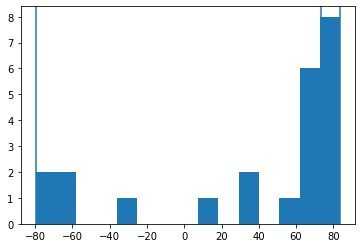

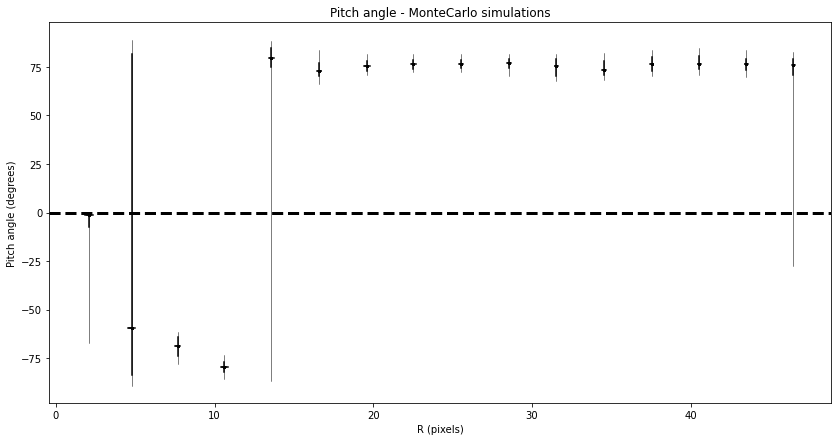

    index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0       0   2.106717   2.234860   1.974022   2.343371   1.819876  -1.113466   
1       1   4.777337   4.857492   4.632970   4.995465   4.555241 -59.282490   
2       2   7.684182   7.754238   7.589946   7.828778   7.480010 -68.603939   
3       3  10.614474  10.734158  10.494369  10.854167  10.403086 -79.447267   
4       4  13.561425  13.635106  13.498449  13.725706  13.451185  79.372840   
5       5  16.599080  16.682737  16.512250  16.728148  16.459516  72.829095   
6       6  19.570206  19.666525  19.484965  19.767781  19.420823  75.271839   
7       7  22.528727  22.592291  22.463774  22.658401  22.396942  76.393025   
8       8  25.549167  25.608940  25.487662  25.651113  25.421629  76.325057   
9       9  28.552753  28.608870  28.500000  28.660743  28.451445  77.075876   
10     10  31.531539  31.594477  31.472574  31.646800  31.427411  75.415818   
11     11  34.526023  34.583879  34.470461  34.62989

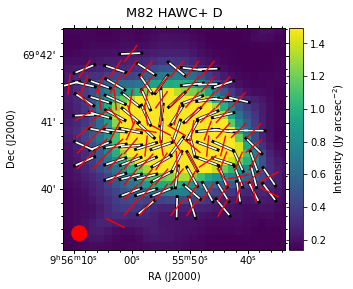

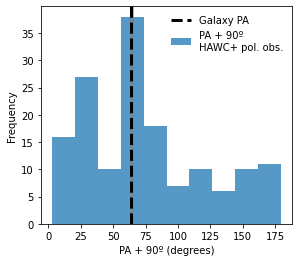

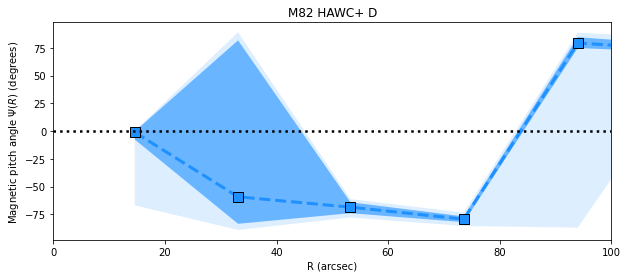

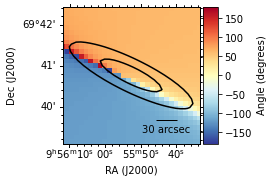

In [9]:
# M82
image_input=legacy_wd+"M82_A.fits"
name="M82_A_"
source_center = m82_center
PA = m82_pa
dPA = 1
incl = m82_incl
dincl = 1
nbins = 20

SNR_int_limit = 80
SNR_pol_limit = SNR_pol_limit_HAWC
plot_title = r'M82 HAWC+ A'

m82_a_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=100)

image_input=legacy_wd+"M82_C.fits"
name="M82_C_"
plot_title = r'M82 HAWC+ C'
m82_c_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=100)

image_input=legacy_wd+"M82_D.fits"
name="M82_D_"
plot_title = r'M82 HAWC+ D'
m82_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=100)



37.55832982758276 39.88663359525209


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 11%|█         | 2/19 [00:00<00:00, 19.99it/s]

Simulations done, generating profile from cube


 63%|██████▎   | 12/19 [00:00<00:00, 14.84it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/81 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    1.424480   1.528282   1.416537   1.533494   1.309178 -28.981209   
1    3.782936   3.798865   3.774933   3.810373   3.768709 -54.427841   
2    6.696899   6.707665   6.678603   6.716866   6.660664 -52.344505   
3    9.617845   9.629121   9.607037   9.639825   9.595126 -45.957063   
4   12.580892  12.601051  12.568742  12.629361  12.559988 -38.427556   
5   15.575841  15.593799  15.552786  15.604175  15.524382 -33.223255   
6   18.574572  18.590290  18.548560  18.602669  18.526951 -34.998573   
7   21.565321  21.584508  21.551481  21.601350  21.535343 -41.766023   
8   24.546156  24.557855  24.538537  24.580010  24.522359 -45.963377   
9   27.530509  27.556801  27.501405  27.575800  27.475760 -52.204088   
10  30.527558  30.552562  30.497974  30.577823  30.467986 -58.240875   
11  33.516052  33.532144  33.501164  33.559107  33.481894 -57.587915   
12  36.536857  36.550761  36.522592  36.579177  36.506788  74.83

100%|██████████| 81/81 [00:02<00:00, 38.75it/s]


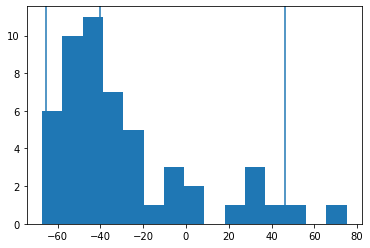

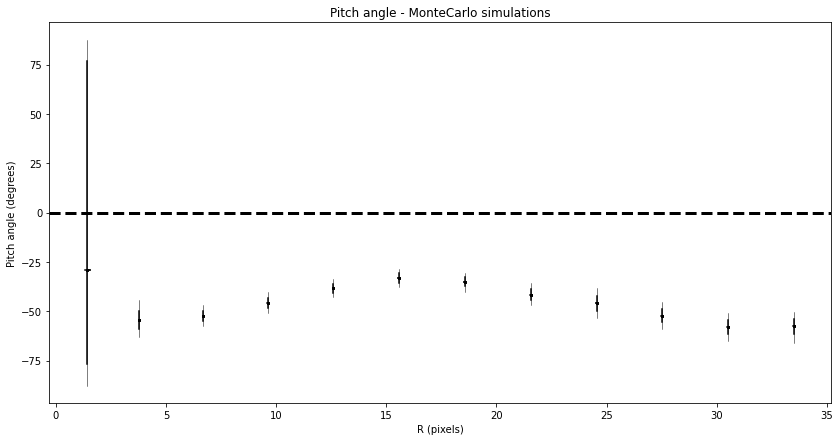

    index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0       0   1.424480   1.528282   1.416537   1.533494   1.309178 -28.981209   
1       1   3.782936   3.798865   3.774933   3.810373   3.768709 -54.427841   
2       2   6.696899   6.707665   6.678603   6.716866   6.660664 -52.344505   
3       3   9.617845   9.629121   9.607037   9.639825   9.595126 -45.957063   
4       4  12.580892  12.601051  12.568742  12.629361  12.559988 -38.427556   
5       5  15.575841  15.593799  15.552786  15.604175  15.524382 -33.223255   
6       6  18.574572  18.590290  18.548560  18.602669  18.526951 -34.998573   
7       7  21.565321  21.584508  21.551481  21.601350  21.535343 -41.766023   
8       8  24.546156  24.557855  24.538537  24.580010  24.522359 -45.963377   
9       9  27.530509  27.556801  27.501405  27.575800  27.475760 -52.204088   
10     10  30.527558  30.552562  30.497974  30.577823  30.467986 -58.240875   
11     11  33.516052  33.532144  33.501164  33.55910

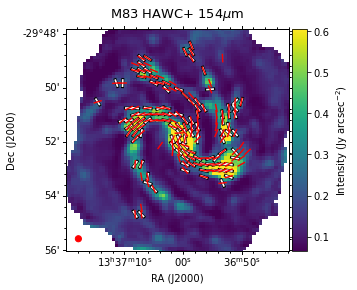

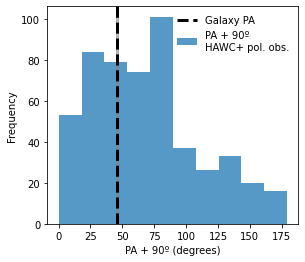

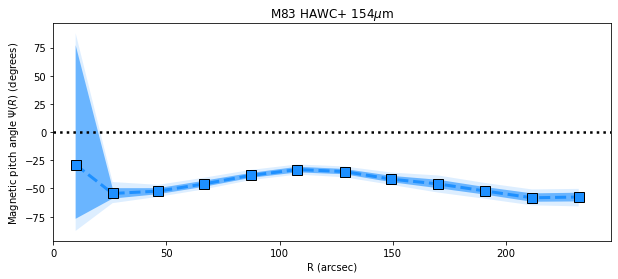

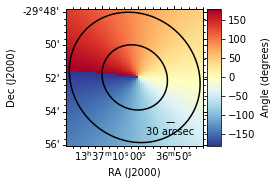

In [10]:
# M83
image_input=legacy_wd+"M83_D.fits"
name="M83_D_"
source_center = m83_center
PA = m83_pa
dPA = 1
incl = m83_incl
dincl = 1
nbins = 20
SNR_int_limit = SNR_int_limit_HAWC
SNR_pol_limit = SNR_pol_limit_HAWC
plot_title = r'M83 HAWC+ 154$\mu$m'

m83_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue")


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

44.77524393028374 41.47049169429186


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 11%|█         | 2/19 [00:00<00:00, 18.73it/s]

Simulations done, generating profile from cube


 42%|████▏     | 8/19 [00:00<00:00, 15.85it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/86 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▌         | 5/86 [00:00<00:01, 40.59it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    2.248425   2.273807   2.160274   2.294605   2.142455 -60.907886   
1    4.747366   4.772313   4.726811   4.806258   4.713837  63.430128   
2    7.669174   7.698541   7.644072   7.721049   7.630011  52.325701   
3   10.666554  10.693460  10.631265  10.715568  10.605120  34.959161   
4   14.141992  14.168921  14.118487  14.193903  14.086355  25.295726   
5   17.606771  17.636880  17.578787  17.658909  17.548406  25.862856   
6   20.583049  20.614889  20.546591  20.641067  20.514323  34.998951   
7   23.553900  23.582663  23.526706  23.604193  23.504203  46.139882   
8   27.065062  27.085524  27.046442  27.112921  27.032848        NaN   
9   30.524611  30.546985  30.498009  30.568329  30.463966        NaN   
10  33.497706  33.522345  33.474151  33.546282  33.460303        NaN   
11  36.501944  36.520322  36.483208  36.546236  36.466230        NaN   
12  40.053633  40.072193  40.037357  40.085044  40.023604       

100%|██████████| 86/86 [00:02<00:00, 39.30it/s]


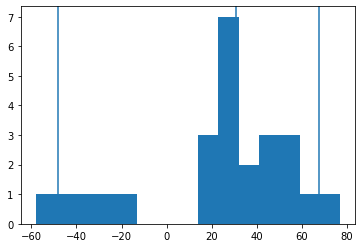

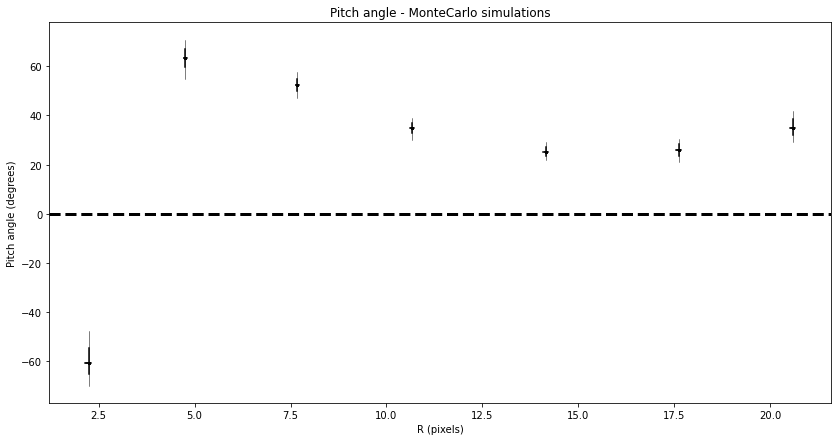

   index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      0   2.248425   2.273807   2.160274   2.294605   2.142455 -60.907886   
1      1   4.747366   4.772313   4.726811   4.806258   4.713837  63.430128   
2      2   7.669174   7.698541   7.644072   7.721049   7.630011  52.325701   
3      3  10.666554  10.693460  10.631265  10.715568  10.605120  34.959161   
4      4  14.141992  14.168921  14.118487  14.193903  14.086355  25.295726   
5      5  17.606771  17.636880  17.578787  17.658909  17.548406  25.862856   
6      6  20.583049  20.614889  20.546591  20.641067  20.514323  34.998951   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0  -54.621458    -65.322455  -47.557865    -69.882568  20.103  
1   67.147550     59.617006   70.893457     54.793796  52.310  
2   54.881202     49.875292   57.781405     47.210691  66.814  
3   36.988971     32.822510   38.815728     30.026814  50.630  
4   27.094074     23.546023   29.038764     21.822186  

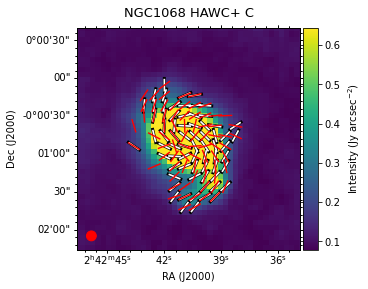

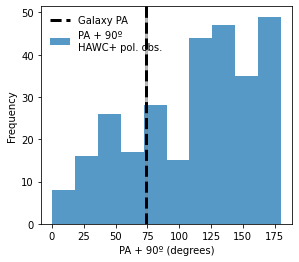

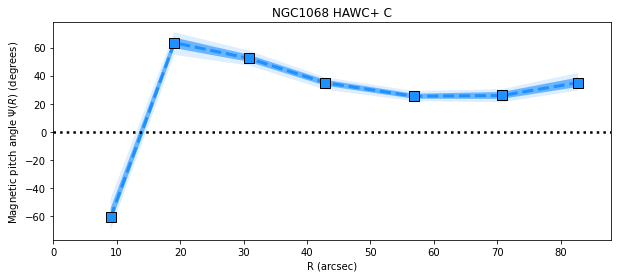

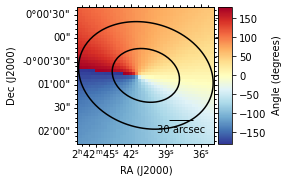

In [11]:
# NGC1068
image_input=legacy_wd+"NGC1068_C.fits"
name="NGC1068_C_"
source_center = ngc1068_center
PA = ngc1068_pa
dPA = 1
incl = ngc1068_incl
dincl = 1
nbins = 20
SNR_int_limit = SNR_int_limit_HAWC
SNR_pol_limit = SNR_pol_limit_HAWC
plot_title = r'NGC1068 HAWC+ C'

ngc1068_c_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue")


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

43.56801865601828 47.277576867142585


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 11%|█         | 2/19 [00:00<00:00, 17.28it/s]

Simulations done, generating profile from cube


 32%|███▏      | 6/19 [00:00<00:00, 13.25it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/94 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  5%|▌         | 5/94 [00:00<00:02, 39.94it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    1.986171   2.131700   1.942894   2.139640   1.937594 -20.953652   
1    4.726958   4.813178   4.635363   4.825708   4.625773 -26.441976   
2    8.227166   8.248427   8.209764   8.283882   8.199246  -9.801100   
3   11.581452  11.596132  11.558642  11.617694  11.531756 -14.191777   
4   14.531867  14.542669  14.522339  14.563270  14.510741  29.798260   
5   18.085770  18.122618  18.062819  18.163756  18.048783  42.876961   
6   21.523483  21.537085  21.503516  21.550573  21.495376        NaN   
7   25.077274  25.089918  25.065477  25.101385  25.051063        NaN   
8   28.510641  28.519788  28.492768  28.550242  28.470022        NaN   
9   31.540169  31.557292  31.525150  31.574151  31.507449        NaN   
10  35.051903  35.090855  35.033123  35.114719  35.022941        NaN   
11  38.511740  38.545129  38.480190  38.580745  38.462633        NaN   
12  42.034402  42.062101  42.002634  42.080161  41.984562       

100%|██████████| 94/94 [00:04<00:00, 22.34it/s]


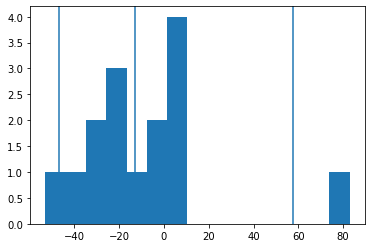

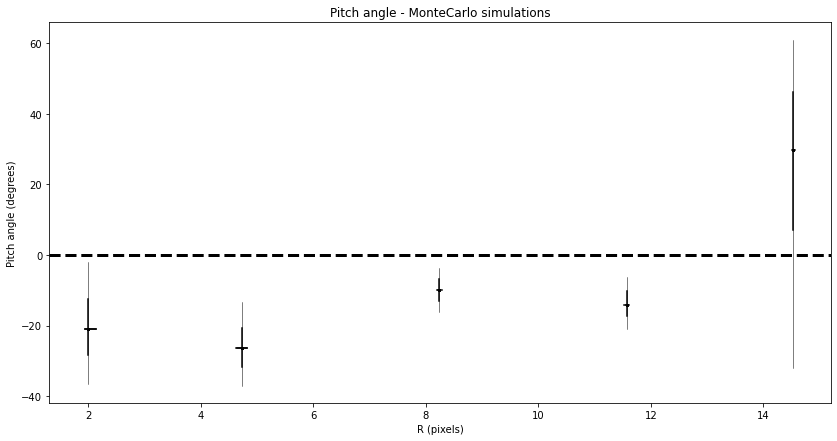

   index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      0   1.986171   2.131700   1.942894   2.139640   1.937594 -20.953652   
1      1   4.726958   4.813178   4.635363   4.825708   4.625773 -26.441976   
2      2   8.227166   8.248427   8.209764   8.283882   8.199246  -9.801100   
3      3  11.581452  11.596132  11.558642  11.617694  11.531756 -14.191777   
4      4  14.531867  14.542669  14.522339  14.563270  14.510741  29.798260   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0  -12.382010    -28.388907   -1.974786    -36.609099  11.522  
1  -20.660482    -31.809934  -13.465683    -36.974996  28.739  
2   -6.745860    -13.132558   -3.746227    -16.262608  40.512  
3  -10.291790    -17.430127   -6.303005    -21.043729  25.450  
4   46.071676      7.074673   60.978625    -31.931447   8.802  
Max radii: 120


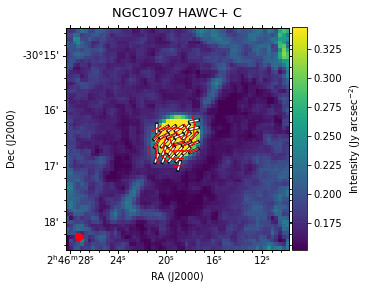

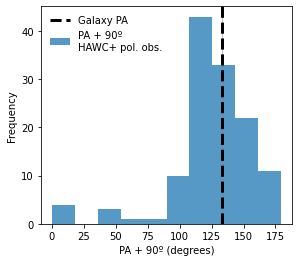

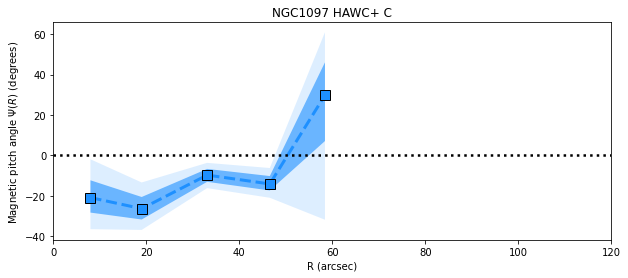

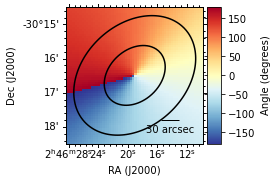

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

36.42416863179827 39.11135621901024


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 16%|█▌        | 3/19 [00:00<00:00, 21.05it/s]

Simulations done, generating profile from cube


/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/78 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▋         | 5/78 [00:00<00:01, 40.71it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    1.455995   1.468117   1.444645   1.479875   1.430183  -3.707818   
1    3.871034   3.871177   3.870840   3.871357   3.863872  -8.034912   
2    6.696049   6.696081   6.686710   6.698342   6.671662 -30.133090   
3    9.674387   9.682495   9.663053   9.685653   9.600805   7.407307   
4   12.552812  12.562735  12.543773  12.568926  12.511757        NaN   
5   15.079123  15.104176  15.047603  15.129093  15.028196        NaN   
6   17.606177  17.634356  17.573977  17.646394  17.552546        NaN   
7   20.506309  20.521549  20.486799  20.533830  20.473824        NaN   
8   23.561848  23.588272  23.538333  23.626143  23.520207        NaN   
9   26.556425  26.583950  26.532110  26.616058  26.516287        NaN   
10  29.020192  29.035346  29.006483  29.050204  28.984290        NaN   
11  31.552637  31.582339  31.524332  31.594529  31.486884        NaN   
12  34.548209  34.558862  34.531686  34.575389  34.492964       

100%|██████████| 78/78 [00:01<00:00, 39.97it/s]


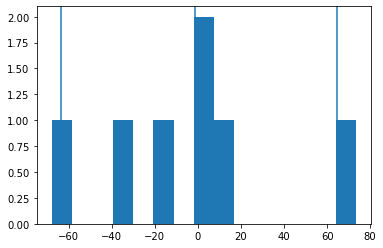

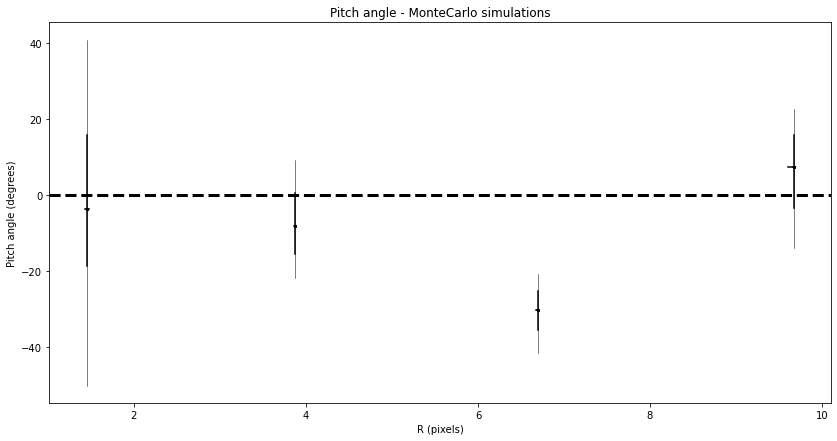

   index         R    R_s1up  R_s1down    R_s2up  R_s2down      pitch  \
0      0  1.455995  1.468117  1.444645  1.479875  1.430183  -3.707818   
1      1  3.871034  3.871177  3.870840  3.871357  3.863872  -8.034912   
2      2  6.696049  6.696081  6.686710  6.698342  6.671662 -30.133090   
3      3  9.674387  9.682495  9.663053  9.685653  9.600805   7.407307   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0   15.834769    -18.605089   41.002419    -50.093432   4.000  
1    0.559350    -15.374142    9.179722    -21.767874  15.074  
2  -25.186618    -35.469290  -20.663034    -41.608861  13.926  
3   15.954730     -3.354979   22.848082    -13.809604   5.000  
Max radii: 120


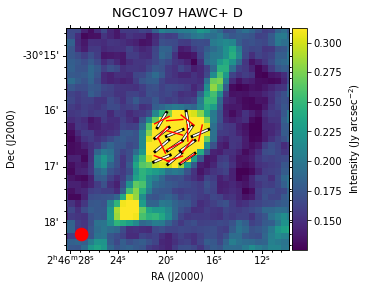

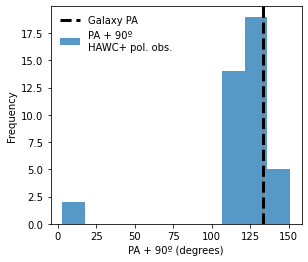

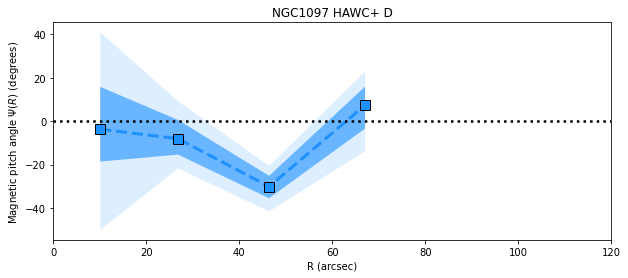

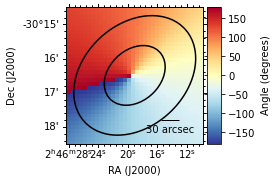

In [12]:
# NGC1097
image_input=legacy_wd+"NGC1097_C.fits"
name="NGC1097_C_"
source_center = ngc1097_center
PA = ngc1097_pa
dPA = ngc1097_dpa
incl = ngc1097_incl
dincl = ngc1097_dincl
nbins = 20
SNR_int_limit = SNR_int_limit_HAWC
SNR_pol_limit = SNR_pol_limit_HAWC
plot_title = r'NGC1097 HAWC+ C'

ngc1097_c_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=120)

image_input=legacy_wd+"NGC1097_D.fits"
name="NGC1097_D_"
plot_title = r'NGC1097 HAWC+ D'
ngc1097_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=120)


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

49.742239253216084 49.699718786720744


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 14%|█▍        | 2/14 [00:00<00:00, 15.26it/s]

Simulations done, generating profile from cube


/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/105 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  4%|▍         | 4/105 [00:00<00:02, 38.46it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    3.445286   3.557275   3.359161   3.627942   3.318252  47.303589   
1    7.879937   7.984649   7.796961   8.071469   7.729964  54.356364   
2   12.739251  12.816736  12.670558  12.887916  12.611362  47.663118   
3   17.662395  17.732827  17.606423  17.802609  17.553015        NaN   
4   22.626374  22.683637  22.570733  22.738965  22.516226        NaN   
5   28.157444  28.190350  28.124881  28.221765  28.092238        NaN   
6   33.597361  33.652751  33.551387  33.693995  33.511451        NaN   
7   38.588161  38.634236  38.544965  38.677039  38.506580        NaN   
8   43.578726  43.625835  43.537087  43.658721  43.501782        NaN   
9   48.568607  48.610573  48.532928  48.648096  48.501169        NaN   
10  53.562887  53.603798  53.527130  53.643217  53.496855        NaN   
11  59.060780  59.093224  59.007621  59.124864  58.951513        NaN   
12  64.453584  64.505388  64.408586  64.545787  64.321372       

100%|██████████| 105/105 [00:02<00:00, 40.25it/s]


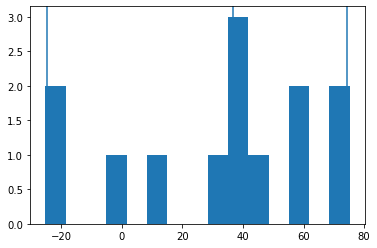

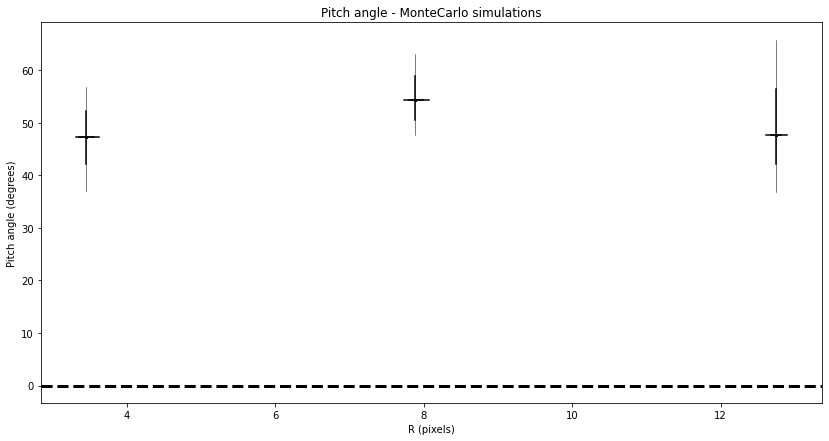

   index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      0   3.445286   3.557275   3.359161   3.627942   3.318252  47.303589   
1      1   7.879937   7.984649   7.796961   8.071469   7.729964  54.356364   
2      2  12.739251  12.816736  12.670558  12.887916  12.611362  47.663118   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0   52.125959     42.175094   56.821906     36.948421  32.578  
1   58.871626     50.502408   63.076501     47.664518  43.553  
2   56.384405     42.122471   65.807128     36.745685   2.869  
Max radii: 100


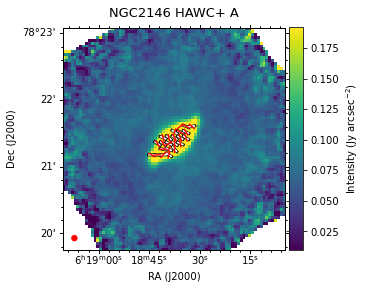

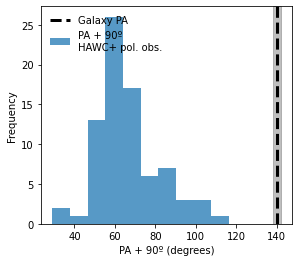

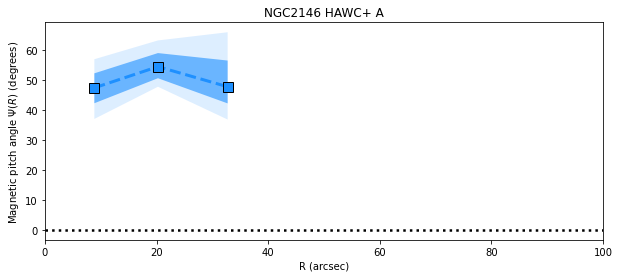

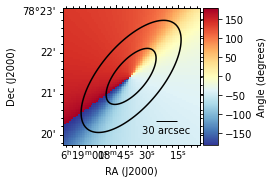

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

36.980007012319206 38.82246934901549


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 21%|██▏       | 3/14 [00:00<00:00, 20.21it/s]

Simulations done, generating profile from cube


 50%|█████     | 7/14 [00:00<00:00, 18.10it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/77 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▋         | 5/77 [00:00<00:01, 40.82it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    2.013021   2.166850   1.943280   2.397127   1.894222  42.795046   
1    5.307512   5.396540   5.258491   5.490999   5.203001  84.290586   
2    9.194719   9.261993   9.127869   9.342174   9.045556  85.528325   
3   13.153555  13.226174  13.077781  13.294994  13.008744  84.548705   
4   17.121082  17.178231  17.056384  17.223126  16.979324 -76.877298   
5   21.096550  21.151829  21.038334  21.189007  20.989726 -74.965496   
6   25.077570  25.133686  25.023208  25.181105  24.984099 -68.008712   
7   29.070433  29.116936  29.020602  29.155705  28.966987 -72.361405   
8   33.059313  33.107807  33.012049  33.156468  32.968287        NaN   
9   37.051949  37.096345  37.013837  37.133491  36.977119        NaN   
10  41.043842  41.089471  41.006520  41.131364  40.976740        NaN   
11  44.515823  44.545743  44.481305  44.573418  44.452320        NaN   
12  47.939935  47.983770  47.899576  48.020612  47.863816       

100%|██████████| 77/77 [00:01<00:00, 39.90it/s]


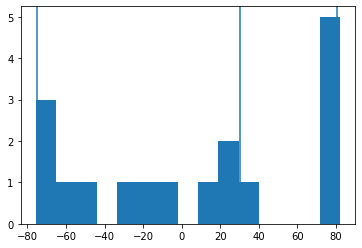

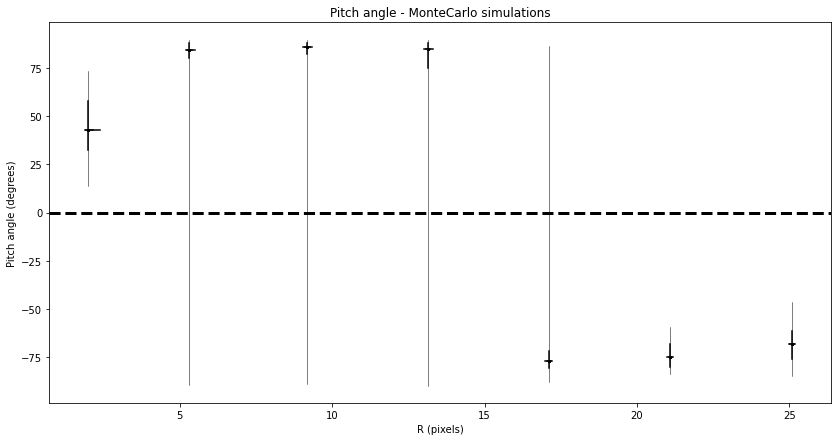

   index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      0   2.013021   2.166850   1.943280   2.397127   1.894222  42.795046   
1      1   5.307512   5.396540   5.258491   5.490999   5.203001  84.290586   
2      2   9.194719   9.261993   9.127869   9.342174   9.045556  85.528325   
3      3  13.153555  13.226174  13.077781  13.294994  13.008744  84.548705   
4      4  17.121082  17.178231  17.056384  17.223126  16.979324 -76.877298   
5      5  21.096550  21.151829  21.038334  21.189007  20.989726 -74.965496   
6      6  25.077570  25.133686  25.023208  25.181105  24.984099 -68.008712   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0   57.870769     32.218151   73.320547     13.543365  11.408  
1   87.631757     80.123390   89.370281    -89.510512  38.426  
2   87.677770     82.247814   89.412011    -88.895431  35.484  
3   87.634087     74.767728   89.579341    -89.606065  18.067  
4  -71.905161    -80.629094   86.406601    -87.590582  

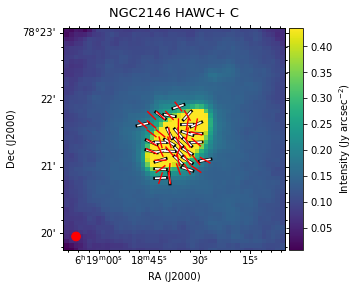

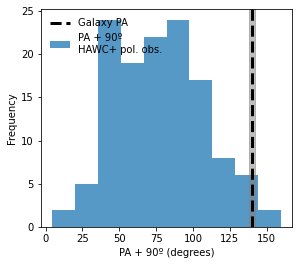

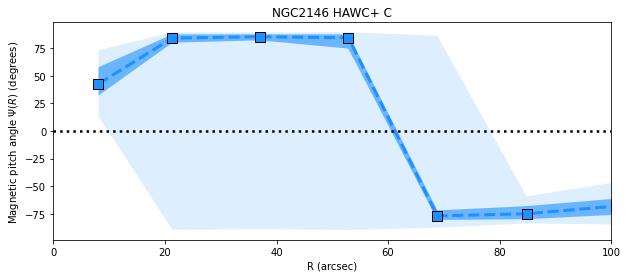

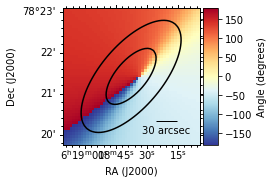

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

40.77844562619382 41.97710343189643


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 14%|█▍        | 2/14 [00:00<00:00, 18.80it/s]

Simulations done, generating profile from cube


 43%|████▎     | 6/14 [00:00<00:00, 16.52it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/87 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▌         | 5/87 [00:00<00:02, 40.88it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    2.829934   2.891179   2.747410   2.987089   2.705790  83.675452   
1    6.261349   6.321284   6.219025   6.416997   6.172347 -84.224733   
2   10.809646  10.851647  10.749334  10.922175  10.683144  63.142932   
3   15.127738  15.203486  15.060439  15.263361  15.017853  50.691987   
4   19.096754  19.163781  19.041113  19.228345  18.994901 -68.524245   
5   23.628223  23.666102  23.594572  23.717059  23.552669 -68.758056   
6   28.066430  28.130233  28.010280  28.174471  27.969705        NaN   
7   32.064443  32.116537  32.013898  32.165244  31.967774        NaN   
8   36.588623  36.617486  36.553726  36.650143  36.515830        NaN   
9   41.045171  41.088189  41.000181  41.128818  40.962921        NaN   
10  45.041177  45.087956  44.997705  45.124454  44.960798        NaN   
11  49.517286  49.564532  49.463071  49.598657  49.423713        NaN   
12  53.983796  54.036759  53.933382  54.077627  53.884393       

100%|██████████| 87/87 [00:02<00:00, 38.37it/s]


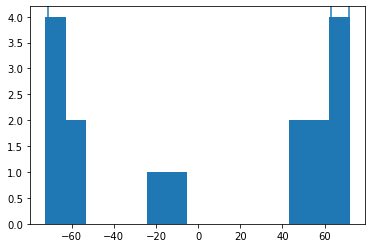

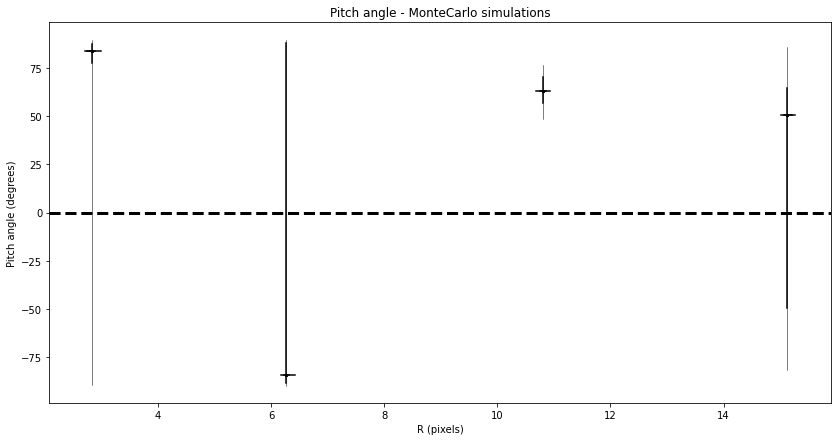

   index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      0   2.829934   2.891179   2.747410   2.987089   2.705790  83.675452   
1      1   6.261349   6.321284   6.219025   6.416997   6.172347 -84.224733   
2      2  10.809646  10.851647  10.749334  10.922175  10.683144  63.142932   
3      3  15.127738  15.203486  15.060439  15.263361  15.017853  50.691987   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0   87.304126     77.850578   89.507793    -89.398648  18.892  
1   88.187102    -88.389037   89.758133    -89.751386  45.986  
2   70.117542     56.704340   76.440103     48.358546  26.559  
3   64.508421    -49.769603   85.803653    -81.604497   3.940  
Max radii: 100


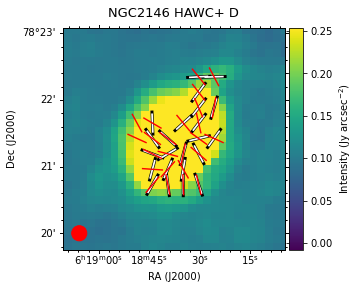

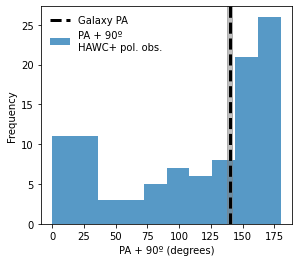

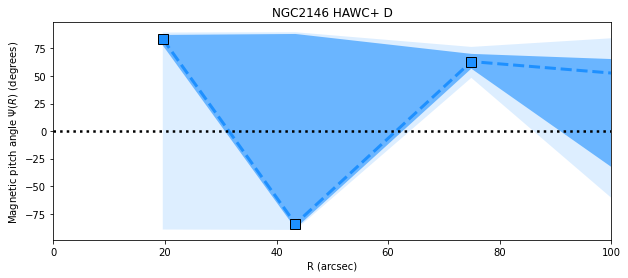

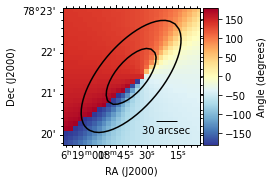

34.70462653123258 38.85061789851986


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 21%|██▏       | 3/14 [00:00<00:00, 19.40it/s]

Simulations done, generating profile from cube


 50%|█████     | 7/14 [00:00<00:00, 17.31it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/80 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  5%|▌         | 4/80 [00:00<00:01, 39.94it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    1.986998   2.040158   1.924430   2.112625   1.834219 -61.368638   
1    5.412748   5.479305   5.369111   5.530449   5.324645 -45.207437   
2    9.239414   9.301134   9.156644   9.353383   9.075344 -20.318719   
3   13.155122  13.198074  13.098183  13.250556  13.018928 -25.270365   
4   17.120655  17.181222  17.053772  17.231654  16.993557 -27.266780   
5   21.089062  21.136086  21.027781  21.175545  20.983775 -77.602072   
6   25.084465  25.139651  25.035799  25.176161  24.996834 -82.073255   
7   29.062926  29.110853  29.017153  29.149934  28.975145 -81.070716   
8   33.058832  33.099797  33.015946  33.129340  32.985084        NaN   
9   37.055102  37.101641  37.011670  37.138389  36.979138        NaN   
10  41.040240  41.080044  40.996445  41.118071  40.956464        NaN   
11  44.991917  45.034500  44.948277  45.071900  44.910488        NaN   
12  48.979866  49.036339  48.919642  49.075463  48.860133       

100%|██████████| 80/80 [00:02<00:00, 39.18it/s]


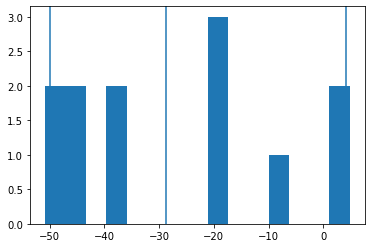

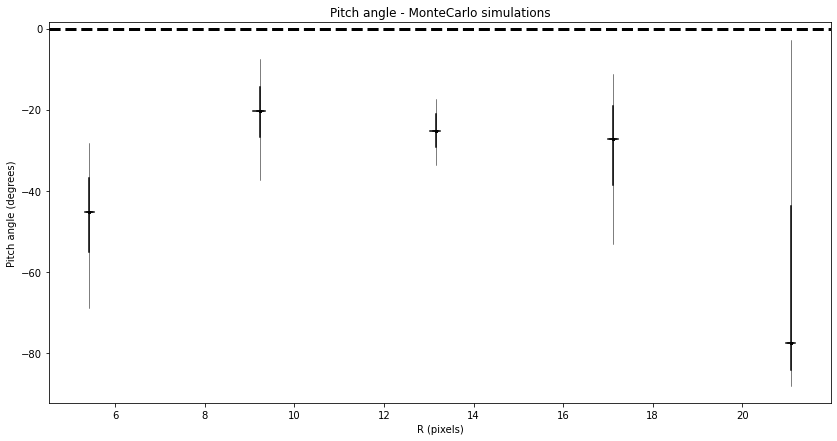

   index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      1   5.412748   5.479305   5.369111   5.530449   5.324645 -45.207437   
1      2   9.239414   9.301134   9.156644   9.353383   9.075344 -20.318719   
2      3  13.155122  13.198074  13.098183  13.250556  13.018928 -25.270365   
3      4  17.120655  17.181222  17.053772  17.231654  16.993557 -27.266780   
4      5  21.089062  21.136086  21.027781  21.175545  20.983775 -77.602072   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0  -36.999828    -55.087412  -28.156069    -68.930614   9.227  
1  -14.393417    -26.765060   -7.639880    -37.434069  14.381  
2  -21.104386    -29.336006  -17.303894    -33.805859  21.361  
3  -19.070473    -38.531524  -11.104935    -53.185874  17.709  
4  -43.818349    -84.347872   -2.731442    -88.103224   9.474  
Max radii: 100


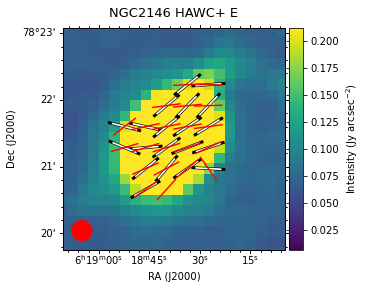

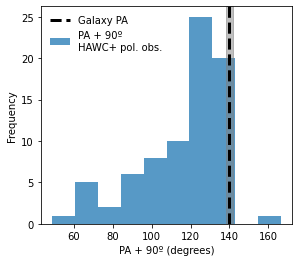

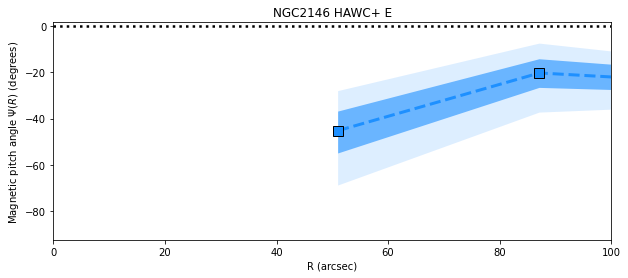

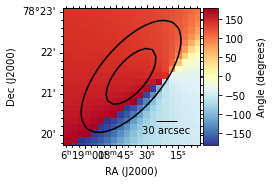

In [13]:
# NGC2146
source_center = ngc2146_center
PA = ngc2146_pa
dPA = ngc2146_dpa
incl = ngc2146_incl
dincl = ngc2146_dincl
nbins = 15

SNR_int_limit = 80
SNR_pol_limit = SNR_pol_limit_HAWC

image_input=legacy_wd+"NGC2146_A.fits"
name="NGC2146_A_"
plot_title = r'NGC2146 HAWC+ A'
ngc2146_a_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=100)

image_input=legacy_wd+"NGC2146_C.fits"
name="NGC2146_C_"
plot_title = r'NGC2146 HAWC+ C'
ngc2146_c_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=100)

image_input=legacy_wd+"NGC2146_D.fits"
name="NGC2146_D_"
plot_title = r'NGC2146 HAWC+ D'
ngc2146_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit,
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=100)

image_input=legacy_wd+"NGC2146_E.fits"
name="NGC2146_E_"
plot_title = r'NGC2146 HAWC+ E'
ngc2146_e_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=100)


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

42.93740850020471 41.60679914817206


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 11%|█         | 2/19 [00:00<00:00, 18.55it/s]

Simulations done, generating profile from cube


 42%|████▏     | 8/19 [00:00<00:00, 15.90it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/86 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  6%|▌         | 5/86 [00:00<00:02, 40.25it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    2.124666   2.134518   2.118399   2.155740   2.113889   3.724944   
1    4.641908   4.712992   4.591655   4.751540   4.553186  35.959440   
2    7.600418   7.642283   7.555825   7.682354   7.533299  34.298286   
3   10.546774  10.580039  10.517862  10.629653  10.491489  21.418442   
4   14.084979  14.116717  14.056904  14.150421  14.035557  11.660727   
5   17.530126  17.562814  17.498000  17.589524  17.460557 -12.728446   
6   20.516924  20.543543  20.491903  20.571347  20.456408 -18.917458   
7   23.519453  23.543396  23.495545  23.567901  23.471348  -4.297417   
8   26.516782  26.538217  26.494408  26.563151  26.471850   5.322004   
9   30.068337  30.096775  30.035042  30.117320  30.007304        NaN   
10  33.503864  33.525581  33.482608  33.543537  33.461464        NaN   
11  36.500685  36.521298  36.482243  36.542488  36.462320        NaN   
12  39.499747  39.518818  39.481122  39.541278  39.465266       

100%|██████████| 86/86 [00:02<00:00, 39.96it/s]


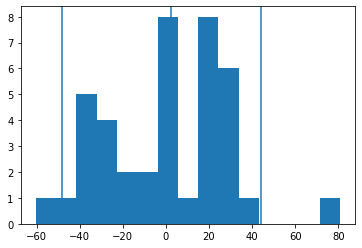

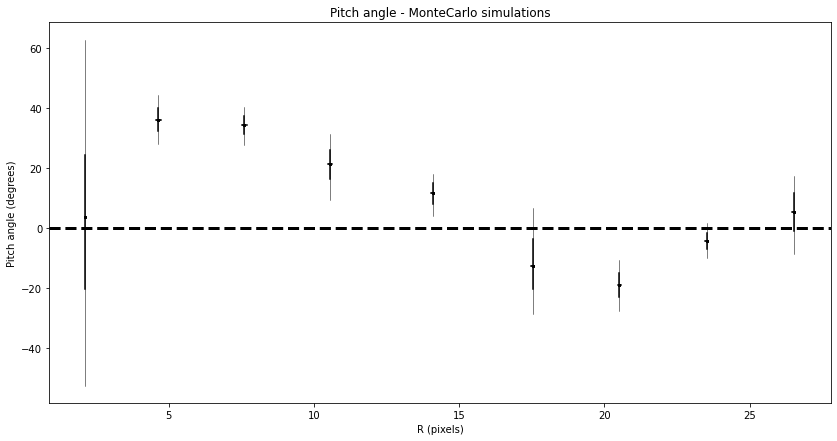

   index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      0   2.124666   2.134518   2.118399   2.155740   2.113889   3.724944   
1      1   4.641908   4.712992   4.591655   4.751540   4.553186  35.959440   
2      2   7.600418   7.642283   7.555825   7.682354   7.533299  34.298286   
3      3  10.546774  10.580039  10.517862  10.629653  10.491489  21.418442   
4      4  14.084979  14.116717  14.056904  14.150421  14.035557  11.660727   
5      5  17.530126  17.562814  17.498000  17.589524  17.460557 -12.728446   
6      6  20.516924  20.543543  20.491903  20.571347  20.456408 -18.917458   
7      7  23.519453  23.543396  23.495545  23.567901  23.471348  -4.297417   
8      8  26.516782  26.538217  26.494408  26.563151  26.471850   5.322004   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down     npix  
0   24.112808    -20.287033   62.754989    -52.579885   10.892  
1   40.036858     32.141049   44.365665     27.931110   29.788  
2   37.293593     31.208

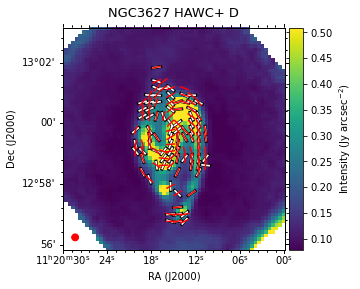

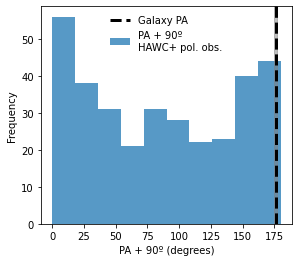

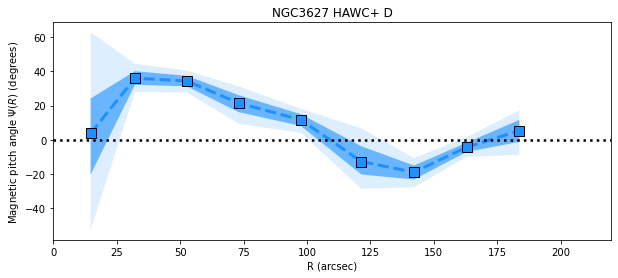

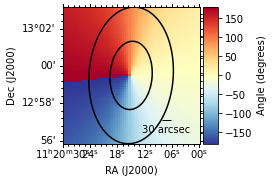

In [14]:
# NGC3627
source_center = ngc3627_center
PA = ngc3627_pa
dPA = ngc3627_dpa
incl = ngc3627_incl
dincl = ngc3627_dincl
nbins = 20
SNR_int_limit = SNR_int_limit_HAWC
SNR_pol_limit = SNR_pol_limit_HAWC

image_input=legacy_wd+"NGC3627_D.fits"
name="NGC3627_D_"
plot_title = r'NGC3627 HAWC+ D'

ngc3627_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=220)

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

53.41604974580546 54.4509591452542


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 11%|█         | 2/19 [00:00<00:01, 14.47it/s]

Simulations done, generating profile from cube


 74%|███████▎  | 14/19 [00:01<00:00, 10.40it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/108 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  4%|▎         | 4/108 [00:00<00:02, 39.04it/s]

            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    2.828198   2.864702   2.793566   2.962724   2.760210  -4.582370   
1    6.404301   6.471227   6.323146   6.493950   6.259018 -24.085307   
2   10.205035  10.281557  10.140516  10.324496  10.099091 -31.590941   
3   14.140505  14.174251  14.093903  14.204736  14.055842 -31.084903   
4   18.102057  18.147750  18.064838  18.183854  18.037155 -26.504821   
5   22.084910  22.123398  22.053416  22.161422  22.025176 -27.594520   
6   26.076847  26.110118  26.038541  26.149206  26.010493 -28.346110   
7   30.065615  30.101737  30.030002  30.139492  30.001855  64.641565   
8   34.056184  34.092529  34.020877  34.121458  33.995573 -79.534032   
9   38.051836  38.080628  38.020836  38.112000  37.997228 -79.207087   
10  42.043137  42.075789  42.014683  42.103396  41.994675 -10.367972   
11  46.041853  46.068341  46.012928  46.091619  45.993892 -22.323009   
12  50.038417  50.065626  50.013558  50.090817  49.993017 -52.76

100%|██████████| 108/108 [00:02<00:00, 40.60it/s]


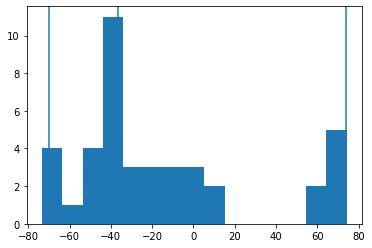

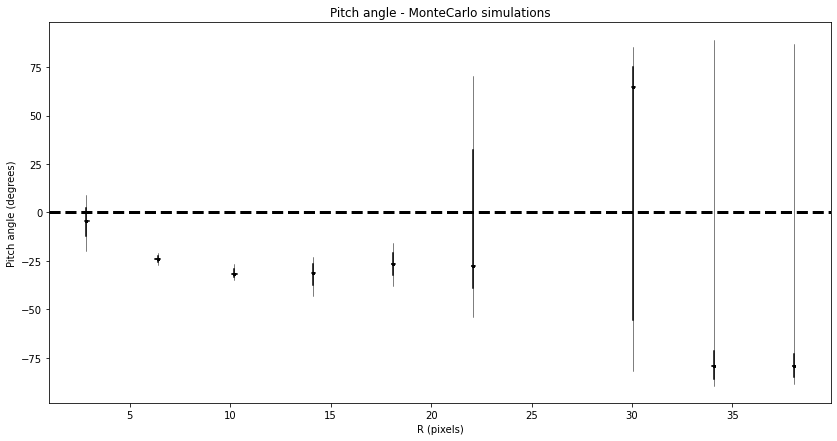

   index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      0   2.828198   2.864702   2.793566   2.962724   2.760210  -4.582370   
1      1   6.404301   6.471227   6.323146   6.493950   6.259018 -24.085307   
2      2  10.205035  10.281557  10.140516  10.324496  10.099091 -31.590941   
3      3  14.140505  14.174251  14.093903  14.204736  14.055842 -31.084903   
4      4  18.102057  18.147750  18.064838  18.183854  18.037155 -26.504821   
5      5  22.084910  22.123398  22.053416  22.161422  22.025176 -27.594520   
6      7  30.065615  30.101737  30.030002  30.139492  30.001855  64.641565   
7      8  34.056184  34.092529  34.020877  34.121458  33.995573 -79.534032   
8      9  38.051836  38.080628  38.020836  38.112000  37.997228 -79.207087   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0    2.139153    -11.969740    9.085613    -19.876008  29.909  
1  -22.553210    -25.719618  -20.902362    -26.939472  97.915  
2  -29.415816    -33.466992

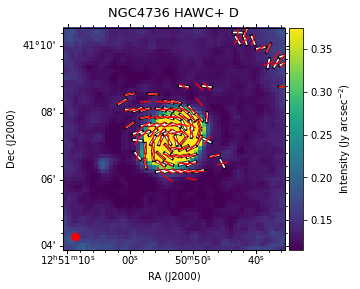

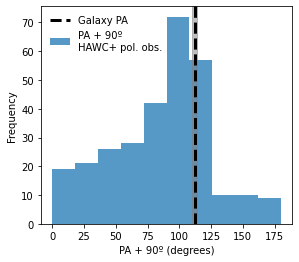

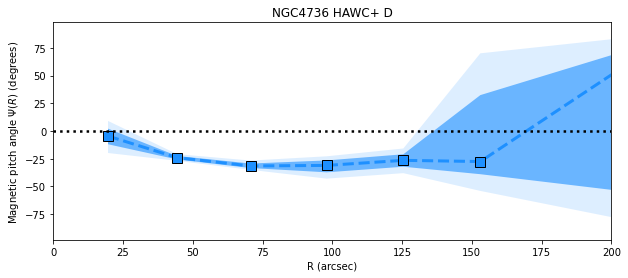

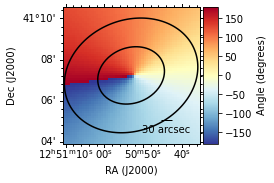

In [15]:
# NGC4736
source_center = ngc4736_center
PA = ngc4736_pa
dPA = ngc4736_dpa
incl = ngc4736_incl
dincl = ngc4736_dincl
nbins = 20
SNR_int_limit = SNR_int_limit_HAWC
SNR_pol_limit = SNR_pol_limit_HAWC

image_input=legacy_wd+"NGC4736_D.fits"
name="NGC4736_D_"
plot_title = r'NGC4736 HAWC+ D'

ngc4736_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=200)

61.055856267088046 60.011073758395256


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 11%|█         | 2/19 [00:00<00:01, 12.56it/s]

Simulations done, generating profile from cube


 68%|██████▊   | 13/19 [00:01<00:00,  9.12it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 19/19 [00:02<00:00,  8.80it/s]


            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    2.828256   2.859046   2.791854   2.925364   2.725752 -72.409817   
1    7.090718   7.135225   6.987775   7.179442   6.899138 -27.956778   
2   11.192760  11.259831  11.131314  11.285842  11.101787 -63.798461   
3   15.736867  15.764794  15.697237  15.791986  15.669271  64.174515   
4   20.105620  20.135370  20.062351  20.170398  20.035280  21.620995   
5   24.610800  24.646863  24.580218  24.682872  24.548514 -25.683547   
6   29.087959  29.116820  29.053741  29.142054  29.022064 -45.561096   
7   33.613295  33.640054  33.593886  33.664838  33.571200  55.371107   
8   38.592122  38.612972  38.568228  38.637341  38.550659 -55.660049   
9   43.046520  43.069352  43.024625  43.091836  43.004306 -52.316551   
10  47.551344  47.580173  47.527592  47.610989  47.513963  54.706488   
11  52.035868  52.063964  52.012640  52.085804  51.993700  49.576393   
12  56.556385  56.584476  56.534083  56.607581  56.513594  51.88

  0%|          | 0/121 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 121/121 [00:02<00:00, 40.62it/s]


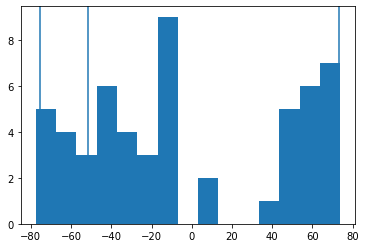

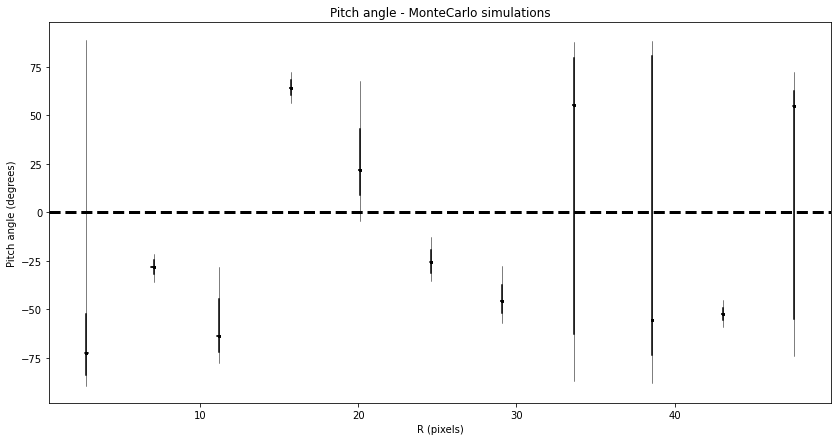

    index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0       0   2.828256   2.859046   2.791854   2.925364   2.725752 -72.409817   
1       1   7.090718   7.135225   6.987775   7.179442   6.899138 -27.956778   
2       2  11.192760  11.259831  11.131314  11.285842  11.101787 -63.798461   
3       3  15.736867  15.764794  15.697237  15.791986  15.669271  64.174515   
4       4  20.105620  20.135370  20.062351  20.170398  20.035280  21.620995   
5       5  24.610800  24.646863  24.580218  24.682872  24.548514 -25.683547   
6       6  29.087959  29.116820  29.053741  29.142054  29.022064 -45.561096   
7       7  33.613295  33.640054  33.593886  33.664838  33.571200  55.371107   
8       8  38.592122  38.612972  38.568228  38.637341  38.550659 -55.660049   
9       9  43.046520  43.069352  43.024625  43.091836  43.004306 -52.316551   
10     10  47.551344  47.580173  47.527592  47.610989  47.513963  54.706488   

    pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2d

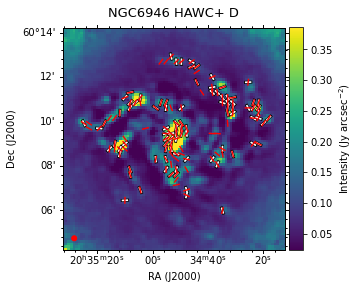

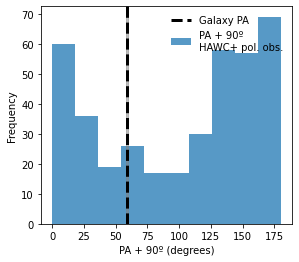

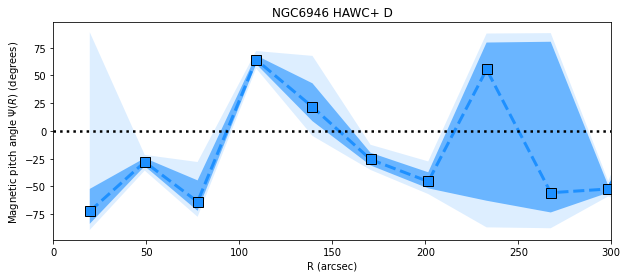

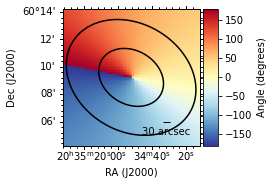

In [16]:
# NGC6946
source_center = ngc6946_center
PA = ngc6946_pa
dPA = ngc6946_dpa
incl = ngc6946_incl
dincl = ngc6946_dincl
nbins = 20
SNR_int_limit = SNR_int_limit_HAWC
SNR_pol_limit = SNR_pol_limit_HAWC

image_input=legacy_wd+"NGC6946_D.fits"
name="NGC6946_D_"
plot_title = r'NGC6946 HAWC+ D'

ngc6946_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit,
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=300)

/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]

60.580761209844106 57.65256514693928


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 22%|██▏       | 2/9 [00:00<00:00, 11.97it/s]

Simulations done, generating profile from cube


 78%|███████▊  | 7/9 [00:00<00:00,  8.87it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  0%|          | 0/115 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
  3%|▎         | 4/115 [00:00<00:02, 39.28it/s]

           R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0   6.380617   6.471344   6.275565   6.586570   6.172653 -56.107100   
1  14.227591  14.306040  14.146709  14.382226  14.052391 -47.319892   
2  22.941342  23.008175  22.883785  23.068859  22.826064 -59.121644   
3  31.819699  31.874851  31.771295  31.928403  31.727749 -69.696128   
4  40.748653  40.797509  40.706888  40.843469  40.667503 -75.285300   
5  50.249786  50.289474  50.209242  50.328603  50.173816 -80.347940   
6  59.670228  59.707230  59.633810  59.744461  59.598994 -82.050106   
7  68.392300  68.594756  68.254478  68.663993  68.186896        NaN   
8  77.272097  77.418233  77.052780  77.487254  76.965598        NaN   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0  -45.055997    -69.098633  -32.883401    -81.444931  14.820  
1  -39.928039    -57.115194  -31.777384    -71.890837  17.658  
2  -52.833718    -64.197835  -45.338900    -68.707693   6.105  
3  -65.535611    -73.176966  -56.

100%|██████████| 115/115 [00:02<00:00, 39.61it/s]


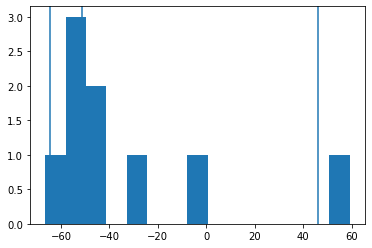

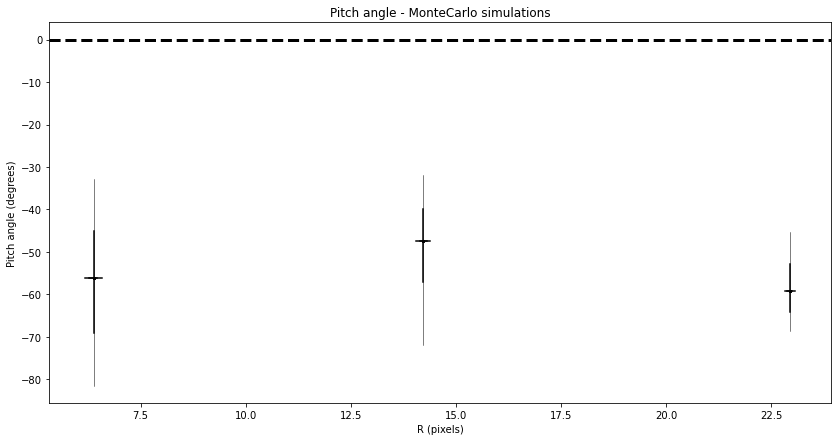

   index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0      0   6.380617   6.471344   6.275565   6.586570   6.172653 -56.107100   
1      1  14.227591  14.306040  14.146709  14.382226  14.052391 -47.319892   
2      2  22.941342  23.008175  22.883785  23.068859  22.826064 -59.121644   

   pitch_s1up  pitch_s1down  pitch_s2up  pitch_s2down    npix  
0  -45.055997    -69.098633  -32.883401    -81.444931  14.820  
1  -39.928039    -57.115194  -31.777384    -71.890837  17.658  
2  -52.833718    -64.197835  -45.338900    -68.707693   6.105  
Max radii: 100


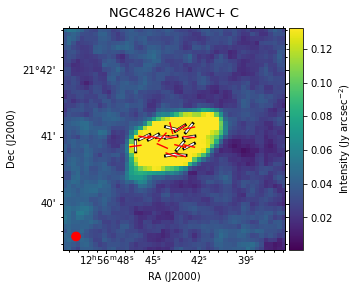

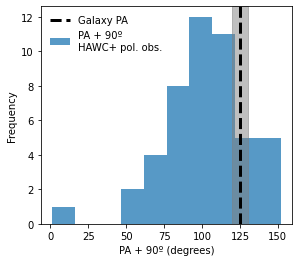

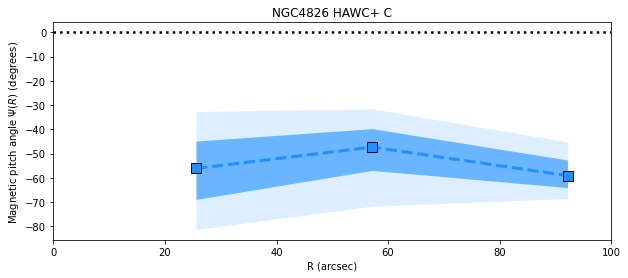

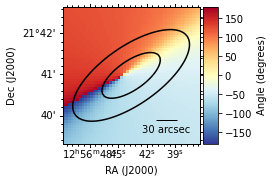

In [17]:
# NGC4826
source_center = ngc4826_center
PA = ngc4826_pa
dPA = ngc4826_dpa
incl = ngc4826_incl
dincl = ngc4826_dincl
nbins = 10
SNR_int_limit = SNR_int_limit_HAWC
SNR_pol_limit = SNR_pol_limit_HAWC

image_input=legacy_wd+"NGC4826_C.fits"
name="NGC4826_C_"
plot_title = r'NGC4826 HAWC+ C'

ngc4826_c_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit,
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=100)

45.54440192342832 46.64760594282438


/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:852: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
  0%|          | 0/1000 [00:00<?, ?it/s]/home/borlaff/NASA/SOFIA/MOHAWC/mohawc.py:629: RuntimeWarning: invalid value encountered in sqrt
  pol_dbias = np.sqrt(pol_level**2 - dpol_level**2)
 11%|█         | 2/19 [00:00<00:01, 16.59it/s]

Simulations done, generating profile from cube


  0%|          | 0/94 [00:00<?, ?it/s]/home/borlaff/miniconda2/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


            R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0    2.192505   2.471112   1.935676   2.631315   1.817501  26.688488   
1    4.892419   5.097899   4.713410   5.347492   4.598549 -70.895810   
2    8.256575   8.430080   8.101167   8.607069   7.992788 -73.095064   
3   11.606172  11.815038  11.408685  11.951033  11.302032 -70.940473   
4   15.115918  15.236163  14.993051  15.353610  14.859211 -61.045229   
5   18.527036  18.671830  18.378525  18.786188  18.279887 -60.237254   
6   22.099936  22.206312  21.983285  22.293317  21.850965 -55.126828   
7   25.536132  25.636307  25.430971  25.719321  25.329603 -49.841779   
8   29.075288  29.179456  28.965472  29.266054  28.880532 -55.450542   
9   32.551802  32.646609  32.453351  32.721720  32.384748 -60.844872   
10  36.065841  36.150728  35.972146  36.224798  35.879933 -65.247200   
11  39.545119  39.639404  39.445179  39.701485  39.386458 -67.721836   
12  43.048061  43.124211  42.970070  43.210260  42.888486 -69.27

100%|██████████| 94/94 [00:02<00:00, 38.14it/s]


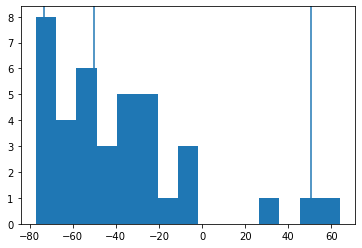

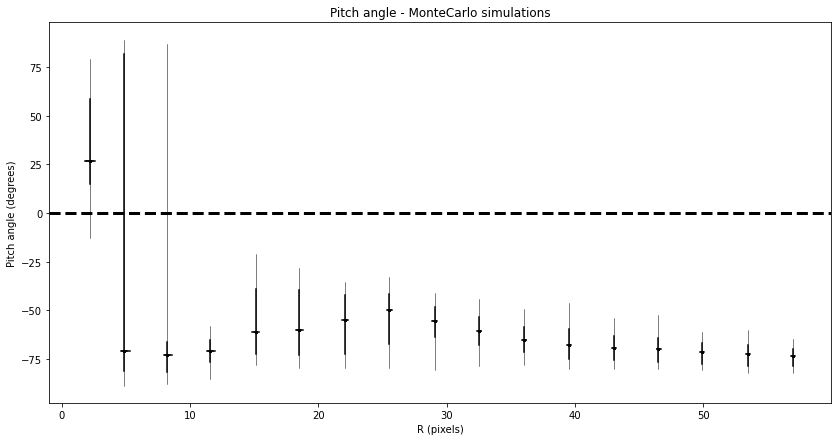

    index          R     R_s1up   R_s1down     R_s2up   R_s2down      pitch  \
0       0   2.192505   2.471112   1.935676   2.631315   1.817501  26.688488   
1       1   4.892419   5.097899   4.713410   5.347492   4.598549 -70.895810   
2       2   8.256575   8.430080   8.101167   8.607069   7.992788 -73.095064   
3       3  11.606172  11.815038  11.408685  11.951033  11.302032 -70.940473   
4       4  15.115918  15.236163  14.993051  15.353610  14.859211 -61.045229   
5       5  18.527036  18.671830  18.378525  18.786188  18.279887 -60.237254   
6       6  22.099936  22.206312  21.983285  22.293317  21.850965 -55.126828   
7       7  25.536132  25.636307  25.430971  25.719321  25.329603 -49.841779   
8       8  29.075288  29.179456  28.965472  29.266054  28.880532 -55.450542   
9       9  32.551802  32.646609  32.453351  32.721720  32.384748 -60.844872   
10     10  36.065841  36.150728  35.972146  36.224798  35.879933 -65.247200   
11     11  39.545119  39.639404  39.445179  39.70148

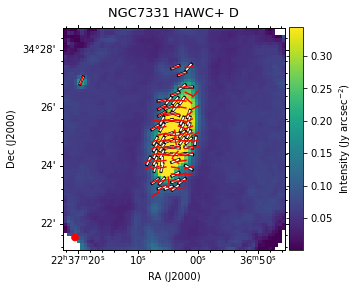

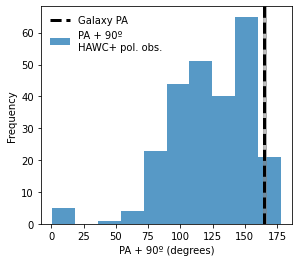

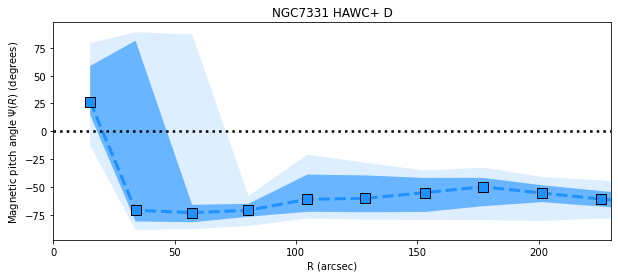

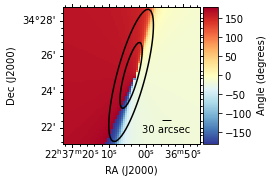

In [18]:
# NGC7331
image_input=legacy_wd+"NGC7331_D.fits"
name="NGC7331_D_"
source_center = ngc7331_center
PA = ngc7331_pa
dPA = ngc7331_dpa
incl = ngc7331_incl
dincl = ngc7331_dincl
nbins = 20
SNR_int_limit = SNR_int_limit_HAWC
SNR_pol_limit = SNR_pol_limit_HAWC
plot_title = r'NGC7331 HAWC+ D'

ngc7331_d_profile = magnetic_pitch_wrapper(image_input=image_input, name=name, source_center=source_center,
                                            PA=PA, dPA=dPA, incl=incl, dincl=dincl, nbins=nbins, nsimul=nsimul,
                                            SNR_int_limit=SNR_int_limit, SNR_pol_limit=SNR_pol_limit, 
                                            SNR_polflux_limit=SNR_polflux_limit, p_limit=p_limit,
                                            plot_title=plot_title, profile_color="dodgerblue", max_radii=230)

In [19]:
#### 
